# Agriculture Data Analysis

In [1]:
from __future__ import division, print_function, unicode_literals
from numpy import *
import numpy as np
import matplotlib.pyplot as mplot
import matplotlib.pylab as plt
import matplotlib.cm as cm
import matplotlib as mpl
import pandas as pd
import seaborn as sns #Need to install
import scipy.stats as stats
import pylab
import warnings
warnings.filterwarnings('ignore')
from itertools import cycle
from sklearn.cluster import KMeans as km
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import Lasso as LS
from sklearn.linear_model import Ridge as RG
from sklearn.tree import DecisionTreeRegressor as scart
from sklearn.manifold import TSNE
%matplotlib inline

# Data reading and cleaning
#### 1. Reading the main file for agricultural data:
- Main DB that has crop area and production information for each state from 1997.

In [2]:
crop_prod=pd.read_csv('crop_prod.csv',delimiter=',')
crop_prod=crop_prod.fillna(0)
# print(crop_prod.dtypes)

In [3]:
crop_prod.sort_values(by=crop_prod.columns[0])
states = sorted(set(crop_prod.iloc[:,0].values))
crop_prod.head()

,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
0,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Arecanut,1254.0,2000.0
1,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Other Kharif pulses,2.0,1.0
2,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Rice,102.0,321.0
3,Andaman and Nicobar Islands,NICOBARS,2000,Whole Year,Banana,176.0,641.0
4,Andaman and Nicobar Islands,NICOBARS,2000,Whole Year,Cashewnut,720.0,165.0


#### 2. Reading the DB with wholesale price of crops over the years.
- Commodities are crop
- The prices are in Rupees / Quintal

In [4]:
crop_price=pd.read_csv("Crops_price.csv",delimiter=',')
for i in range(1,crop_price.shape[1]):
    crop_price.iloc[:,i]=pd.to_numeric(crop_price.iloc[:,i],errors='coerce')
    crop_price.iloc[:,i]=crop_price.iloc[:,i].fillna(0)
crop_price = crop_price.rename(columns = {'Commodities(rs/quin)':'Commodities'})
crop_price.head()

,Commodities,2002,2004,2005,2006,2007,2008,2009,2010,2011,2012
0,Paddy (Common),550.0,560.0,570.0,580.0,645.0,850.0,950.0,1000.0,1080,1250.0
1,Paddy (Grade ‘A’),580.0,590.0,600.0,610.0,675.0,880.0,980.0,1030.0,1110,1280.0
2,Wheat,630.0,640.0,650.0,750.0,1000.0,1080.0,1100.0,1120.0,1285,1350.0
3,Jowar (Hybrid),490.0,515.0,525.0,540.0,600.0,840.0,840.0,880.0,980,1500.0
4,Jowar (Maldandi),0.0,0.0,0.0,555.0,620.0,860.0,860.0,900.0,1000,1520.0


#### 3. Including DB for area under cultivation for major crops

In [5]:
area_cult=pd.read_csv("area_cult.csv",delimiter=',')
# print(sum(area_cult.isna()))
area_cult.head()

,Year,Rice,Jowar,Bajra,Maize,Ragi,Small millets,Wheat,Barley,Gram,...,Rubber,Banana,Sugarcane,Tobacco,Potato,Black pepper,Dry chillies,Ginger,Coconut,Turmeric
0,2000,44712,9856,9829,6611,1759,1424,25731,778,5185,...,400,459,4316,262,1222,214,836,86,1824,192
1,2001,44904,9795,9529,6582,1647,1310,26345,660,6416,...,401,489,4412,348,1208,219,880,91,1932,167
2,2002,41176,9300,7740,6635,1415,1201,25196,702,5906,...,408,460,4520,327,1345,224,827,88,1922,150
3,2003,42593,9331,10612,7343,1666,1191,26595,657,7048,...,428,391,3938,370,1289,233,774,85,1934,150
4,2004,41907,9092,8233,7430,1553,1101,26383,616,6715,...,440,404,3662,366,1318,228,738,95,1935,159


#### 4. Reading database for cost of cultivation of crops in that state
- Information is in three parts : 
- A2 (actual paid out cost), A2+FL (actual paid out cost plus imputed value of family labour) 
- C2 (comprehensive cost including imputed rent and interest on owned land and capital). As is evident, C2 > A2+FL > A2.
- Cost of production per quintal.

In [6]:
culti_cost=pd.read_csv("culti_cost.csv",delimiter=',')
culti_cost=culti_cost.fillna(0)
# print(sum(culti_cost.isna()))
state_cult = sorted(set(culti_cost.iloc[:,1]))
print(culti_cost.shape)
culti_cost.head()

(50, 20)


,Crop,State/ UT Name,Cost of Cultivation (`/Hectare) - A2+FL - 2008-09,Cost of Cultivation (`/Hectare) - A2+FL - 2009-10,Cost of Cultivation (`/Hectare) - A2+FL - 2010-11,Cost of Cultivation (`/Hectare) - A2+FL - 2011-12,Cost of Cultivation (`/Hectare) - A2+FL - 2012-13,Cost of Cultivation (`/Hectare) - A2+FL - 2013-14,Cost of Cultivation(`/Hectare) - C2 - 2008-09,Cost of Cultivation(`/Hectare) - C2 - 2009-10,Cost of Cultivation(`/Hectare) - C2 - 2010-11,Cost of Cultivation(`/Hectare) - C2 - 2011-12,Cost of Cultivation (`/Hectare) - C2 - 2012-13,Cost of Cultivation (`/Hectare) - C2 - 2013-14,Cost of Production (`/Quintal) - C2 - 2008-09,Cost of Production (`/Quintal) - C2 - 2009-10,Cost of Production (`/Quintal) - C2 - 2010-11,Cost of Production (`/Quintal) - C2 - 2011-12,Cost of Production (`/Quintal) - C2 - 2012-13,Cost of Production (`/Quintal) - C2 - 2013-14
0,Paddy,Andhra Pradesh,29664.84,35104.80,35090.78,37946.69,42669.85,46781.05,46450.20,54202.54,51505.34,58027.19,68149.69,72417.05,789.90,932.50,916.98,976.36,1135.01,1248.20
1,Paddy,Odisha,17478.05,19175.75,21894.98,27243.15,31723.25,35569.85,25909.05,28143.88,30318.40,35972.50,44091.78,46839.15,715.04,793.65,955.59,1221.44,1159.54,1408.40
2,Paddy,Punjab,25154.75,29031.73,30793.25,31248.72,37103.96,39686.81,45291.24,50650.21,51279.34,53813.93,64811.36,68382.86,669.86,773.18,836.46,904.30,945.73,1043.27
3,Paddy,Uttar Pradesh,17022.00,21336.61,21281.30,28147.45,29436.98,30982.85,28144.50,32327.78,32299.35,40146.68,43620.87,45617.43,732.62,812.97,806.87,957.83,1019.43,1031.23
4,Paddy,West Bengal,24731.06,28101.85,32872.72,37959.78,42770.22,45783.94,33046.12,38111.55,43019.85,49142.99,55982.79,60924.19,731.25,865.12,1022.83,1085.76,1236.05,1366.80


## Visualizing databases :
#### Crop prices data  

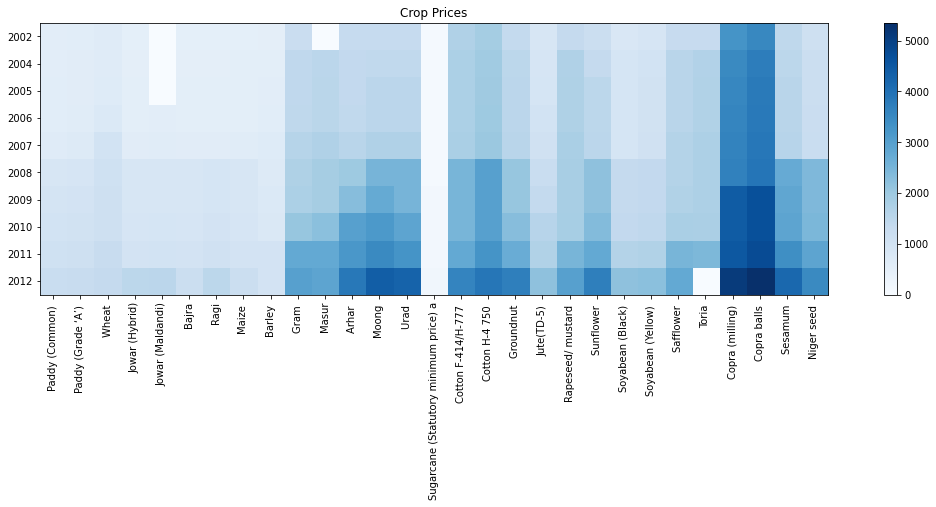

In [7]:
mat1 = np.matrix(crop_price.values[:,1:],dtype='float')
fig = plt.figure(num=2,figsize=(20,5))
ax = fig.add_subplot(1,1,1)
plt.imshow(mat1.T, cmap='Blues')
ax.set_yticks(np.arange(len(crop_price.columns[1:])))
ax.set_xticks(np.arange(len(crop_price.iloc[:,0])))
ax.set_yticklabels(crop_price.columns[1:])
ax.set_xticklabels(crop_price.iloc[:,0],rotation='vertical')
plt.colorbar()
plt.title('Crop Prices')
plt.show()

#### Area under cultivation data

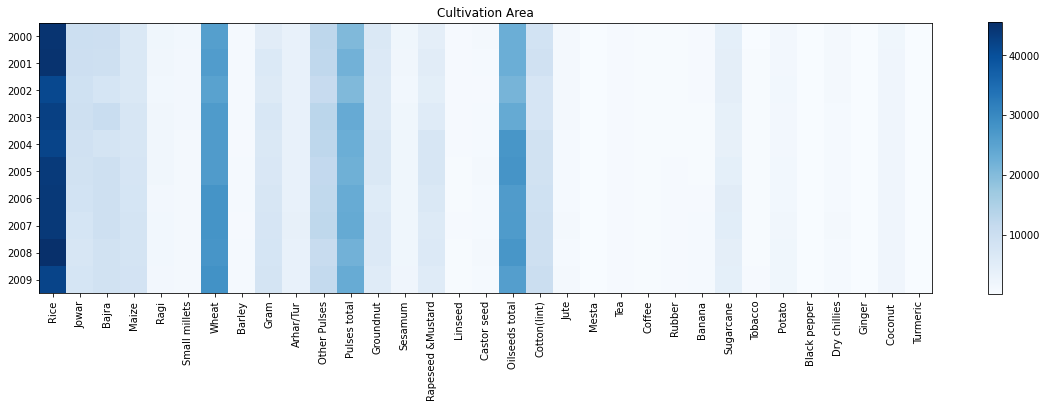

In [8]:
mat2 = np.matrix(area_cult.values[:,1:],dtype='float')
# print(mat2.shape)
mat2=np.delete(mat2,12,1)
# print(mat2.shape)
fig = plt.figure(num=3,figsize=(20,5))
ax = fig.add_subplot(1,1,1)
# ax.set_aspect('equal')
ax.set_xticks(np.arange(len(np.delete(area_cult.columns[1:],12))))
ax.set_yticks(np.arange(len(area_cult.iloc[:,0])))
ax.set_xticklabels(np.delete(area_cult.columns[1:],12),rotation='vertical')
ax.set_yticklabels(area_cult.iloc[:,0])
plt.imshow(mat2, cmap='Blues')
plt.colorbar()
plt.title('Cultivation Area')
plt.show()

#### Cultivation cost of major crops (A2+FL and c2):

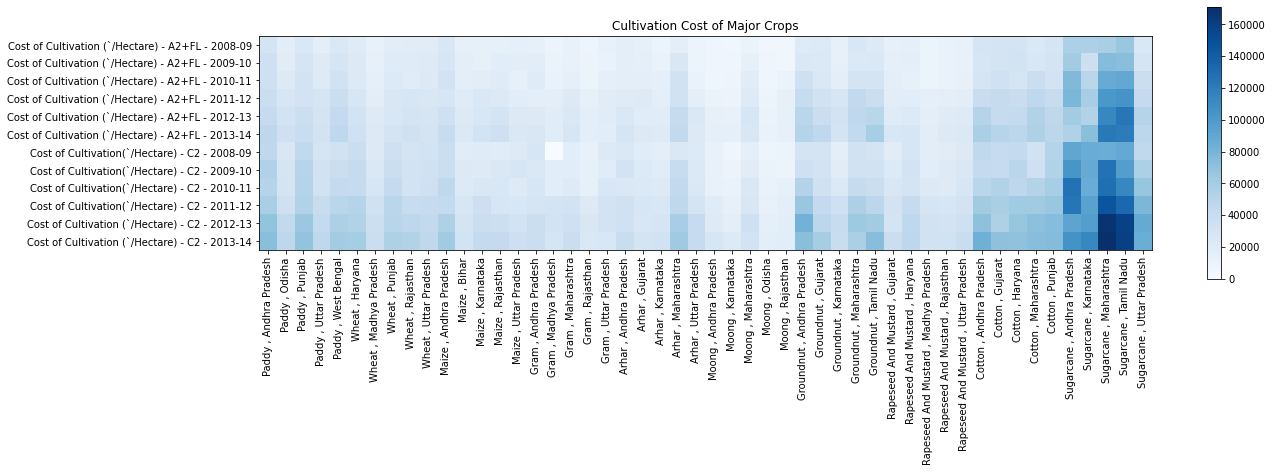

In [9]:
mat3 = np.matrix(culti_cost.values[:,2:14],dtype='float').T
fig = plt.figure(num=3,figsize=(20,5))
ax = fig.add_subplot(1,1,1)
# ax.set_aspect('equal')
ax.set_yticks(np.arange(len(culti_cost.columns[2:14])))
ax.set_xticks(np.arange(len(culti_cost.values[:,0]+' , '+culti_cost.values[:,1])))
ax.set_yticklabels(culti_cost.columns[2:14])
ax.set_xticklabels(culti_cost.values[:,0]+' , '+culti_cost.values[:,1],rotation='vertical')
plt.imshow(mat3, cmap='Blues')
plt.colorbar()
plt.title('Cultivation Cost of Major Crops')
plt.show()

#### Cultivation cost of major crops per quintal in that state:

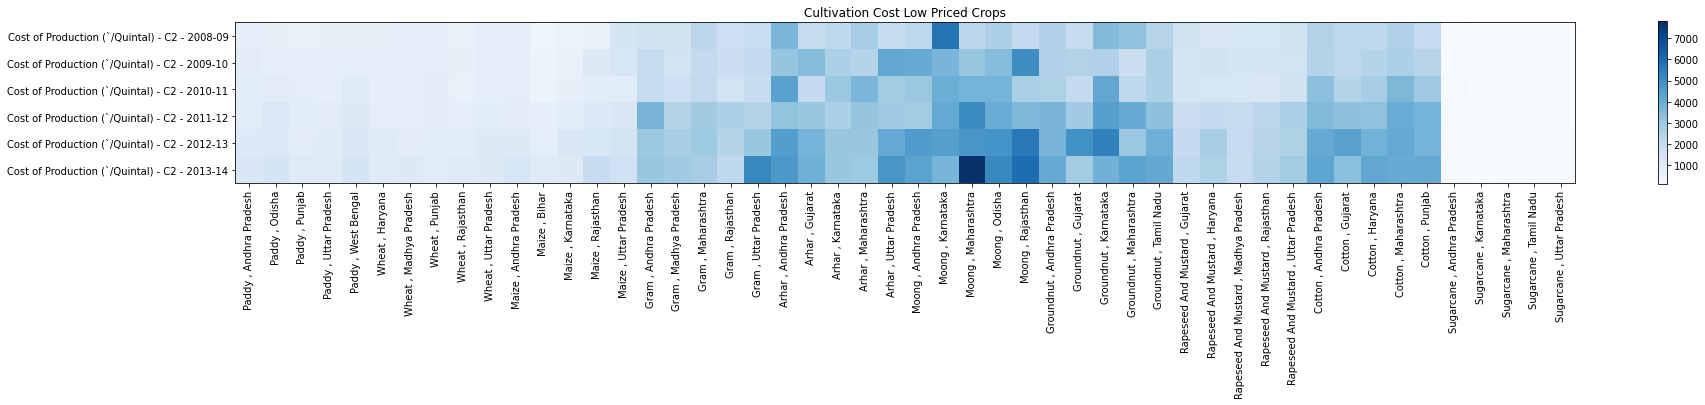

In [10]:
mat4 = np.matrix(culti_cost.values[:,14:],dtype='float').T
fig = plt.figure(num=4,figsize=(30,3))
ax = fig.add_subplot(1,1,1)
# ax.set_aspect('equal')
ax.set_yticks(np.arange(len(culti_cost.columns[14:])))
ax.set_xticks(np.arange(len(culti_cost.values[:,0]+' , '+culti_cost.values[:,1])))
ax.set_yticklabels(culti_cost.columns[14:])
ax.set_xticklabels(culti_cost.values[:,0]+' , '+culti_cost.values[:,1],rotation='vertical')
plt.imshow(mat4, cmap='Blues')
plt.colorbar()
plt.title('Cultivation Cost Low Priced Crops')
plt.show()

#### 5. Reading mean temperatures over the years from database

In [11]:
temperature = pd.read_csv('Mean_Temperatures.csv',delimiter=',')
temperature.head()

,YEAR,ANNUAL,JAN-FEB,MAR-MAY,JUN-SEP,OCT-DEC
0,2000,24.60,19.33,26.47,27.23,22.68
1,2001,24.73,19.75,26.82,27.47,22.52
2,2002,25.00,19.65,27.22,27.71,22.58
3,2003,24.72,19.82,26.52,27.64,22.23
4,2004,24.74,19.93,27.06,27.33,22.24


#### Visualizing of data for mean temperature over the years

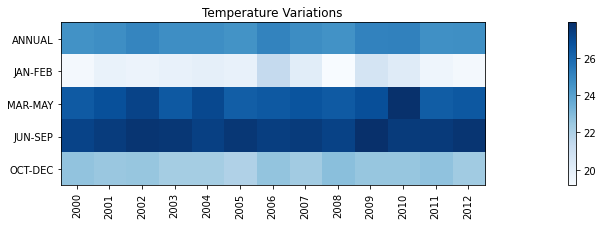

In [12]:
mat5 = np.matrix(temperature.values[:,1:],dtype='float').T
fig = plt.figure(num=5,figsize=(30,3))
ax = fig.add_subplot(1,1,1)
ax.set_yticks(np.arange(len(temperature.columns[1:])))
ax.set_xticks(np.arange(len(temperature.values[:,0])))
ax.set_yticklabels(temperature.columns[1:])
ax.set_xticklabels(temperature.values[:,0].astype(int),rotation='vertical')
plt.imshow(mat5, cmap='Blues')
plt.colorbar()
plt.title('Temperature Variations')
plt.show()

#### 6. Reading the data for year wise rainfall in different states

In [13]:
rainfall =  pd.read_csv('rainfall_cleaned.csv',delimiter=',')
rainfall.head()

,STATES,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL
0,ANDAMAN & NICOBAR ISLANDS,2000,53.0,59.0,171.3,218.1,422.8,357.0,176.3,460.8,250.1,321.2,158.3,115.2,2763.2
1,ANDAMAN & NICOBAR ISLANDS,2001,89.0,15.7,143.3,30.1,705.3,370.7,341.3,469.0,334.4,267.6,222.6,91.8,3080.9
2,ANDAMAN & NICOBAR ISLANDS,2002,10.6,0.0,11.5,100.2,366.7,358.3,317.4,429.8,420.0,169.0,306.7,129.9,2620.2
3,ANDAMAN & NICOBAR ISLANDS,2003,44.3,7.9,149.2,19.4,296.3,159.9,494.9,379.4,371.9,310.4,74.1,48.0,2355.9
4,ANDAMAN & NICOBAR ISLANDS,2004,54.5,35.9,36.5,41.6,505.1,423.9,378.9,308.7,280.7,223.9,169.9,0.4,2460.1


#### Modifying data for observation 

In [14]:
rainfall1=rainfall.copy()
rainfall1 = rainfall1.groupby(['STATES','YEAR'],as_index=True).mean()
# rainfall1.iloc[:,12].unstack(level=-1).reset_index().head()

#### Visualising annual rain data over the years

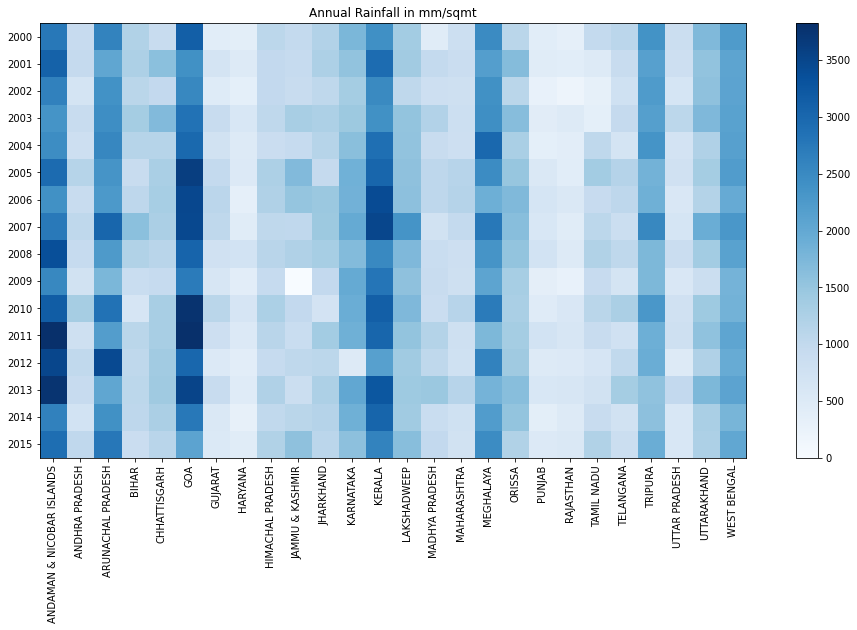

In [15]:
mat6 = np.matrix(rainfall1.iloc[:,12].unstack(level=-1).reset_index().values[:,1:],dtype='float').T
fig = plt.figure(num=6,figsize=(18,8))
ax = fig.add_subplot(1,1,1)
ax.set_yticks(np.arange(len(rainfall1.iloc[:,12].unstack(level=-1).reset_index().columns[1:])))
ax.set_xticks(np.arange(len(rainfall1.iloc[:,12].unstack(level=-1).reset_index().values[:,0])))
ax.set_yticklabels(rainfall1.iloc[:,12].unstack(level=-1).reset_index().columns[1:])
ax.set_xticklabels(rainfall1.iloc[:,12].unstack(level=-1).reset_index().values[:,0],rotation='vertical')
plt.imshow(mat6, cmap='Blues')
plt.colorbar()
plt.title('Annual Rainfall in mm/sqmt')
plt.show()

#### 7. Reading data for growth rate of major crops over the years

In [16]:
growth = pd.read_csv('Avg annual Growth Rate_Major Crops.csv',delimiter = ',')
growth = pd.concat([growth.iloc[:,0],growth.iloc[:,5:]],axis=1,sort=False)
growth = growth.dropna()
growth.head()

,Crop,(Ninth Plan) 1997-98 to 2001-02,(Tenth Plan) 2002-03 to 2006-07,(Eleventh Plan) 2007-08 to 2011-12
0,Wheat,0.7,-0.3,3.0
1,Rice,2.1,1.2,2.2
2,Jowar,0.2,2.1,3.1
3,Bajra,4.9,7.3,8.4
4,Maize,3.1,-0.2,6.5


#### Visualizing growth rate data

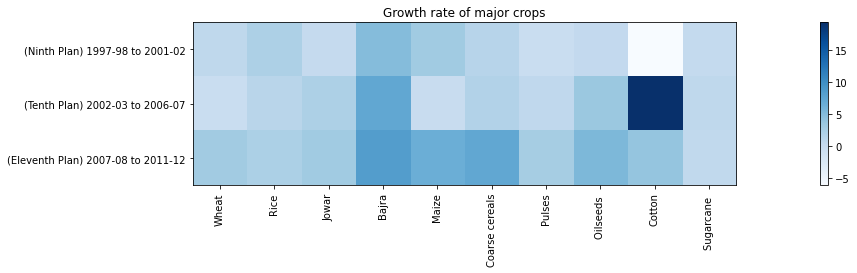

In [17]:
mat7 = np.matrix(growth.values[:,1:],dtype='float').T
fig = plt.figure(num=5,figsize=(30,3))
ax = fig.add_subplot(1,1,1)
ax.set_yticks(np.arange(len(growth.columns[1:])))
ax.set_xticks(np.arange(len(growth.values[:,0])))
ax.set_yticklabels(growth.columns[1:])
ax.set_xticklabels(growth.values[:,0],rotation='vertical')
plt.imshow(mat7, cmap='Blues')
plt.colorbar()
plt.title('Growth rate of major crops')
plt.show()

#### 8. Reading database for number of suicides in several states over the years

In [18]:
suicides = pd.read_csv('suicides_10-14.csv',delimiter = ',')
suicides.drop(columns={'Sl. No.','2014 - Labourers'},inplace=True)
suicides.iloc[:,:].fillna(0,inplace=True)
suicides.head()

,State/UT,2010,2011,2012,2013,2014
0,ANDHRA PRADESH,2525.0,2206.0,2572.0,2014.0,160
1,ARUNACHAL PRADESH,18.0,13.0,11.0,37.0,0
2,ASSAM,369.0,312.0,344.0,305.0,21
3,BIHAR,95.0,83.0,68.0,127.0,0
4,CHHATTISGARH,1126.0,0.0,4.0,0.0,443


#### Visualising the number of suicides data

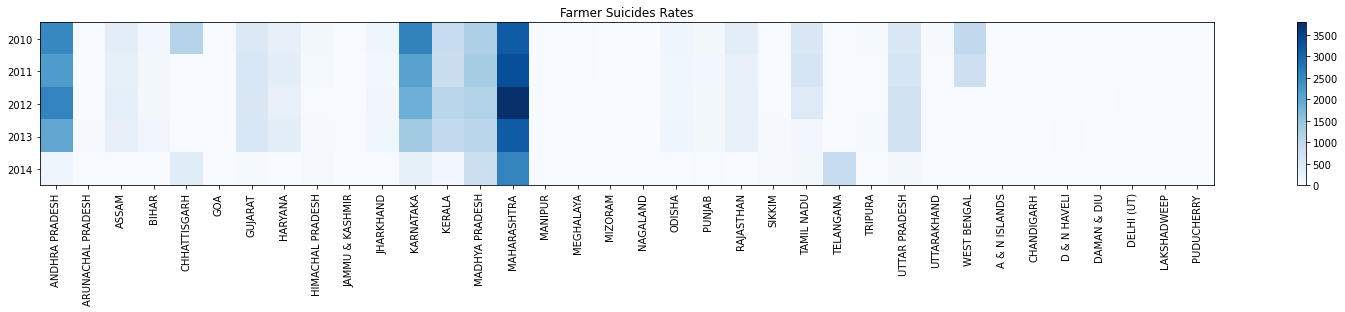

In [19]:
mat8 = np.matrix(suicides.values[:,1:],dtype='float').T
fig = plt.figure(num=5,figsize=(30,3))
ax = fig.add_subplot(1,1,1)
ax.set_yticks(np.arange(len(suicides.columns[1:])))
ax.set_xticks(np.arange(len(suicides.values[:,0])))
ax.set_yticklabels(suicides.columns[1:])
ax.set_xticklabels(suicides.values[:,0],rotation='vertical')
plt.imshow(mat8, cmap='Blues')
plt.colorbar()
plt.title('Farmer Suicides Rates')
plt.show()

#### 9. Reading Exports data for various products over the years

In [20]:
exports = pd.read_csv('IndiaExport.csv',delimiter=',')
to_drop = []
for head in exports.columns[1:]:
    if 'Unn' in head:
        to_drop.append(head)
exports.drop(columns = to_drop,inplace=True)
exports = exports.drop(0)
exports.rename(columns = {'Unnamed: 0':'Product'},inplace = True)
for_plot = exports.copy()
exports = exports.melt(id_vars='Product')
exports.variable = exports.variable.astype(int)
exports.value = exports.value.astype(float)
exports.head()

,Product,variable,value
0,Buffalo Meat,2003,343817.08
1,Basmati Rice,2003,771475.37
2,Rice,2003,2640438.93
3,Guargum,2003,120561.27
4,Wheat,2003,4093080.52


#### Selecting data related only to Agro based products

In [21]:
plot_exports=for_plot.copy()
plot_exports=plot_exports.reset_index(drop=True)
to_drop=[]
ct=0
for head in plot_exports.Product:
    if 'Meat' in head:
        to_drop.append(head)
        plot_exports.drop(ct,inplace=True)
    ct+=1
plot_exports.drop([9,15,23,26,29,32],inplace=True)
plot_exports = plot_exports.reset_index(drop=True)
plot_exports.Product[plot_exports.Product=='Cucumber and Gherkins( Prepd. & Presvd)'] = 'Cucumber and Gherkins'
plot_exports.head()

,Product,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,Basmati Rice,771475.37,1162989.16,1166562.79,1045714.95,1183355.73,1556411.06,2016775,2370658.39,3178174.43,3459898.93,3757271.42,3702260.07
1,Rice,2640438.93,3615109.55,2921601.91,3702191.99,5285916.33,931879.8,139540.76,100685.78,3997719.57,6687990.85,7133183.37,8274046.02
2,Guargum,120561.27,131299.98,186718.4,189304.36,211166.56,258567.56,218479.74,441607.7,707326.43,406311.81,601945.42,665177.71
3,Wheat,4093080.52,2009343.03,746173.23,46633.21,237.27,1120.52,47.3,394.47,740746.76,6514810.6,5562374.74,2924070.18
4,Groundnuts,176109.32,177154.08,190053.34,251428.65,269587.64,297890.37,340246.31,433753.23,832616.93,535637.36,509664.84,708386.26


#### Visualising exports of agro based products

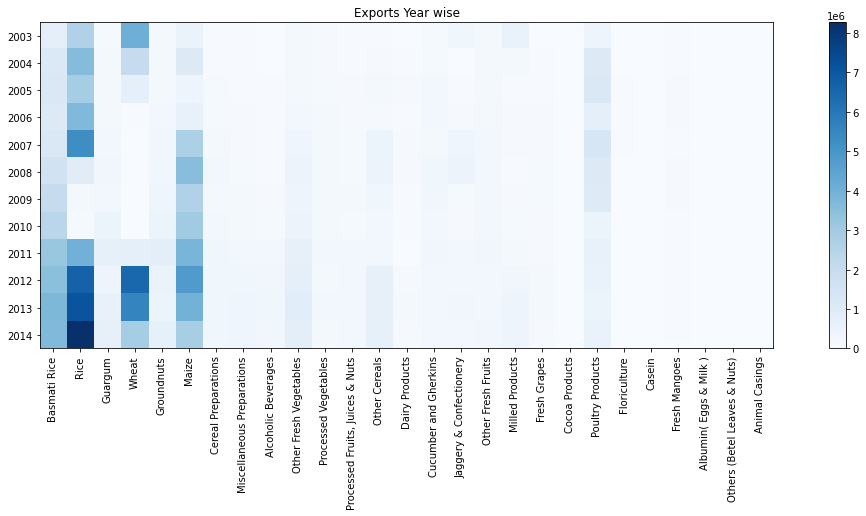

In [22]:
mat8 = np.matrix(plot_exports.values[:,1:],dtype='float').T
fig = plt.figure(num=5,figsize=(20,6))
ax = fig.add_subplot(1,1,1)
ax.set_yticks(np.arange(len(plot_exports.columns[1:])))
ax.set_xticks(np.arange(len(plot_exports.values[:,0])))
ax.set_yticklabels(plot_exports.columns[1:])
ax.set_xticklabels(plot_exports.values[:,0],rotation='vertical')
plt.imshow(mat8, cmap='Blues')
plt.colorbar()
plt.title('Exports Year wise')
plt.show()

#### Separating area data from the main data table 

In [23]:
area = crop_prod.copy()
area = area.loc[area.loc[:,'Crop_Year'] >=2000,:]
area.drop(columns={'Production'},inplace=True)
area = area.groupby(['State_Name','Crop_Year','Crop'],as_index=False,sort=False).sum()
area.head()

,State_Name,Crop_Year,Crop,Area
0,Andaman and Nicobar Islands,2000,Arecanut,4354.0
1,Andaman and Nicobar Islands,2000,Other Kharif pulses,670.0
2,Andaman and Nicobar Islands,2000,Rice,10881.0
3,Andaman and Nicobar Islands,2000,Banana,1707.0
4,Andaman and Nicobar Islands,2000,Cashewnut,800.0


#### Separating production data from main data table

In [24]:
production = pd.concat([crop_prod.iloc[:,0:5],crop_prod.iloc[:,6:7]],axis=1)
production = production.loc[production.loc[:,'Crop_Year'] >=2000,:]
# production.drop(columns={'Production'},inplace=True)
production = production.groupby(['State_Name','Crop_Year','Crop'],as_index=False,sort=False).sum()
production.Crop[production.Crop == 'Paddy'] = 'Rice'
production.Crop[production.Crop == 'Moong(Green Gram)'] = 'Moong'
production.head()

,State_Name,Crop_Year,Crop,Production
0,Andaman and Nicobar Islands,2000,Arecanut,7200.0
1,Andaman and Nicobar Islands,2000,Other Kharif pulses,449.0
2,Andaman and Nicobar Islands,2000,Rice,32184.0
3,Andaman and Nicobar Islands,2000,Banana,12714.0
4,Andaman and Nicobar Islands,2000,Cashewnut,219.0


#### Converting the names in required form in both area and crop price table

In [35]:
area.Crop[area.Crop == 'Paddy'] = 'Rice'
area.Crop[area.Crop == 'Moong(Green Gram)'] = 'Moong'
list_area=sort(area.Crop.unique())
list_price=sort(crop_price.Commodities.unique())
for item in list_price:
    if 'Paddy' in item:
        crop_price.Commodities[crop_price.Commodities == item]='Rice'
for item in list_price:
    for item_area in list_area:
        if item.strip() in item_area or item_area.strip() in item:
            if item != item_area:
                crop_price.Commodities[crop_price.Commodities == item]=item_area
crop_price.Commodities[crop_price.Commodities == 'Cotton F-414/H-777 ']='Cotton(lint)'
crop_price.Commodities[crop_price.Commodities == 'Cotton H-4 750 ']='Cotton(lint)'
crop_price.Commodities[crop_price.Commodities == 'Paddy']='Rice'
crop_price = crop_price.groupby(['Commodities'],as_index=False,sort=False).sum()
# crop_price.head()

In [39]:
# Converting data to make it visualizable
area_price=area.iloc[:,1:]
area_price = area_price.groupby(['Crop_Year','Crop'],as_index=True,sort=False).sum()
area_price = area_price.iloc[:,:].unstack(level=0).reset_index()
area_price = area_price.fillna(0)
area_price.columns = area_price.columns.droplevel()
area_price.rename(columns={'':'Crop'},inplace=True)
area_price = area_price[area_price['Crop'].isin(crop_price.Commodities)].sort_values(by='Crop')
area_price.drop(columns={2000,2001,2003,2013,2014,2015},inplace=True)
area_price.columns = area_price.columns.astype(str)
area_price = area_price.reindex(sorted(area_price.columns), axis=1)
# temp = area_price.iloc[:,1:].reindex(sorted(area_price.iloc[:,1:].columns), axis=1)
area_price.head()

Crop_Year,2002,2004,2005,2006,2007,2008,2009,2010,2011,2012,Crop
17,2963889.15,2912104.08,2875328.46,3297134.83,2287957.63,3113224.0,3221594.0,4289565.0,3752892.0,3220916.0,Arhar/Tur
20,7736866.00,9326100.00,9676568.00,9499237.00,8339105.00,8774882.0,8972422.0,9607246.0,3752948.0,3231616.0,Bajra
76,664523.00,602355.57,614672.00,556516.00,604089.00,685198.0,565424.0,677806.0,325548.0,347179.0,Barley
22,7632933.00,8748496.00,8669295.00,9060875.00,6188044.00,9337428.0,9984615.0,10929723.0,11685196.0,9530632.0,Cotton(lint)
23,5892949.47,6636121.22,6819569.26,7625707.57,6348748.22,7818443.0,7274008.0,8862826.0,6335184.0,6544957.0,Gram


In [40]:
# Selecting the names of crops that are present in both area_price and crop_price table
crop_price = crop_price[crop_price['Commodities'].isin(area_price.Crop)].sort_values(by='Commodities')
crop_price.head()

,Commodities,2002,2004,2005,2006,2007,2008,2009,2010,2011,2012
9,Arhar/Tur,1325.0,1390.0,1400.0,1410.0,1550.0,2000.0,2300.0,3000.0,3200,3850.0
3,Bajra,495.0,515.0,525.0,540.0,600.0,840.0,840.0,880.0,980,1175.0
6,Barley,505.0,540.0,550.0,565.0,650.0,680.0,750.0,780.0,980,980.0
13,Cotton(lint),3590.0,3720.0,3740.0,3760.0,3830.0,5500.0,5500.0,5500.0,6100,7500.0
7,Gram,1225.0,1425.0,1435.0,1445.0,1600.0,1730.0,1760.0,2100.0,2800,3000.0


#### Visualizing the area under cultivation for crops year wise

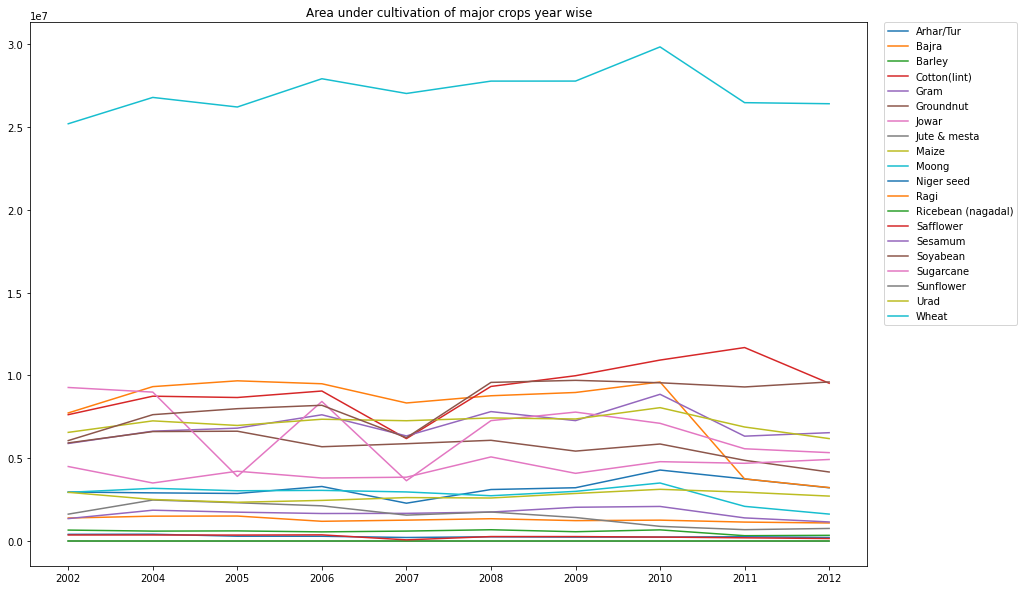

In [43]:
years= area_price.columns[1:]
fig = mplot.figure(figsize=(15,10))
ax1 = fig.add_subplot(111)
colormap = plt.cm.nipy_spectral
# ax1.set_color_cycle([colormap(i) for i in np.linspace(0, 1,area_price.shape[0])])
for i in range(area_price.shape[0]):
    ax1.plot(area_price.columns[:area_price.shape[1]-1],area_price.iloc[i,:area_price.shape[1]-1])
mplot.legend(area_price.iloc[:,area_price.shape[1]-1],bbox_to_anchor=(1.02,1), borderaxespad=0)
mplot.title('Area under cultivation of major crops year wise')
mplot.show()

#### Visualizing the change in prices of crops year wise

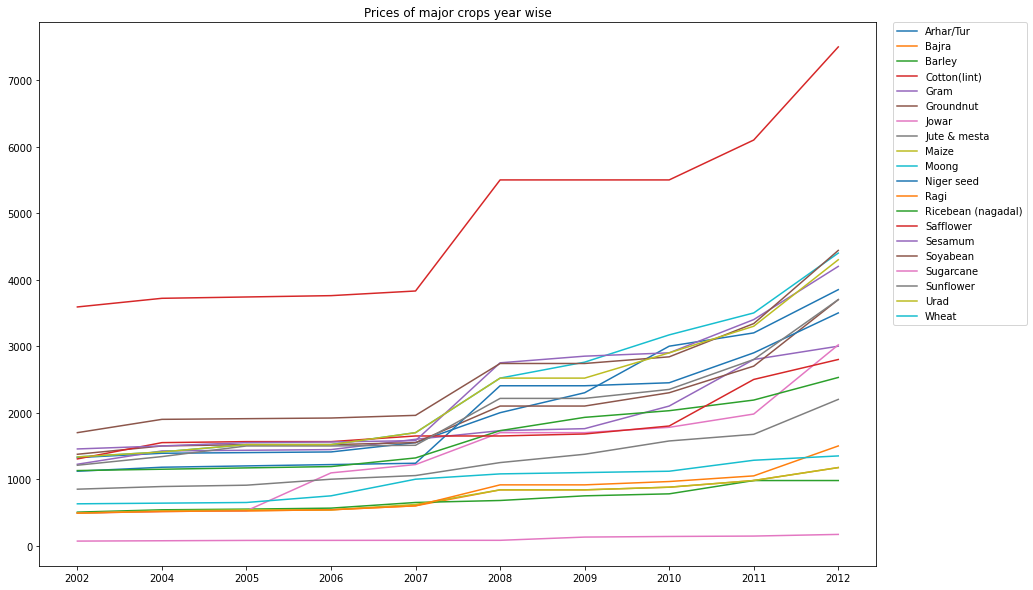

In [44]:
years= crop_price.columns[1:]
fig = mplot.figure(figsize=(15,10))
ax1 = fig.add_subplot(111)
colormap = plt.cm.nipy_spectral
# ax1.set_color_cycle([colormap(i) for i in np.linspace(0, 1,crop_price.shape[0])])
for i in range(crop_price.shape[0]):
    ax1.plot(crop_price.columns[1:],crop_price.iloc[i,1:])
mplot.legend(crop_price.iloc[:,0],bbox_to_anchor=(1.02,1), borderaxespad=0)
mplot.title('Prices of major crops year wise')
mplot.show()

#### Converting production data to compare it from price data

In [45]:
production_year=production.iloc[:,1:]
production_year = production_year.groupby(['Crop_Year','Crop'],as_index=True,sort=False).sum()
production_year = production_year.iloc[:,:].unstack(level=0).reset_index()
production_year = production_year.fillna(0)
production_year.columns = production_year.columns.droplevel()
production_year.rename(columns={'':'Crop'},inplace=True)
production_year = production_year[production_year['Crop'].isin(crop_price.Commodities)].sort_values(by='Crop')
production_year.drop(columns={2000,2001,2003,2013,2014,2015},inplace=True)
production_year.columns = production_year.columns.astype(str)
production_year = production_year.reindex(sorted(production_year.columns), axis=1)
production_year.head()

Crop_Year,2002,2004,2005,2006,2007,2008,2009,2010,2011,2012,Crop
17,1795828.47,1844665.11,2086762.83,2141779.0,1760907.0,2060437.1,2226782.0,2714289.60,2448644.0,2625573.0,Arhar/Tur
20,4713967.30,8051663.00,7118575.80,8334550.0,8857533.2,8900867.0,6517369.0,12269842.00,6073769.0,4877053.0,Bajra
76,1378805.10,1172234.24,1182183.70,1245089.0,1196276.0,1669726.2,1307238.0,1690447.00,777914.0,817666.0,Barley
22,8561894.20,16974350.00,18388534.50,20890976.0,17294926.0,20777198.0,20898065.0,27317346.00,27366253.0,19767509.0,Cotton(lint)
23,4227669.42,5376640.00,5571145.67,6392945.0,4773122.0,6998378.2,6876010.0,7674255.16,5999415.0,6702250.0,Gram


#### Visualizing the production of crops year wise

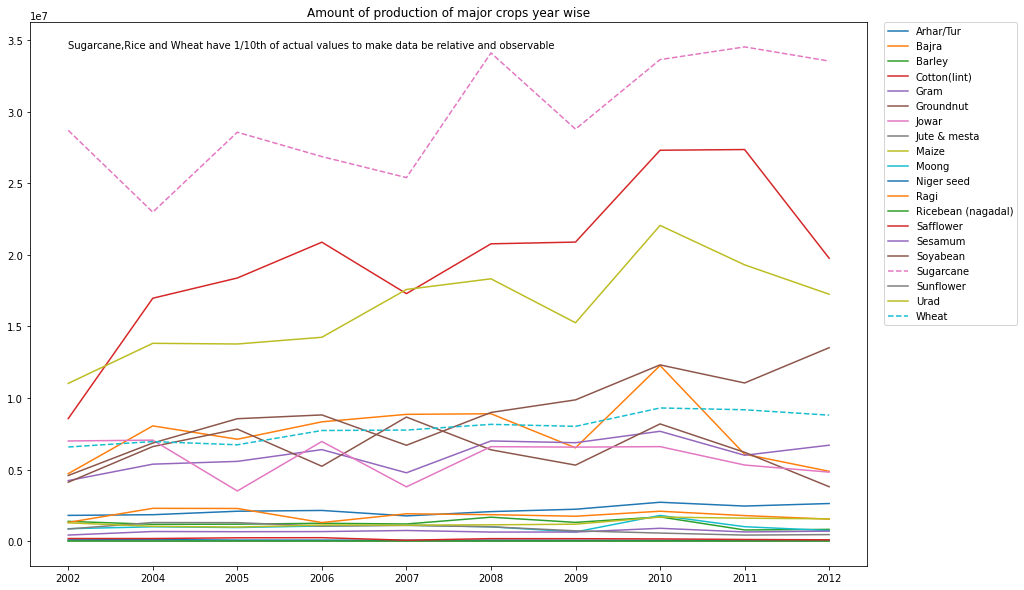

In [47]:
fig = mplot.figure(figsize=(15,10))
t = ("Sugarcane,Rice and Wheat have 1/10th of actual values to make data be relative and observable")
ax1 = fig.add_subplot(111)
colormap = plt.cm.nipy_spectral
# ax1.set_color_cycle([colormap(i) for i in np.linspace(0, 1,production_year.shape[0])])
for i in range(production_year.shape[0]):
    if  production_year.iloc[i,1] < 50000000:
        ax1.plot(production_year.columns[:production_year.shape[1]-1],production_year.iloc[i,:production_year.shape[1]-1])
    else:
        ax1.plot(production_year.columns[:production_year.shape[1]-1],production_year.iloc[i,:production_year.shape[1]-1]/10,linestyle='--')
mplot.legend(production_year.iloc[:,production_year.shape[1]-1],bbox_to_anchor=(1.02,1), borderaxespad=0)
plt.text(0,3.5*10000000, t, ha='left',va='top', rotation=0, wrap=True)
mplot.title('Amount of production of major crops year wise')
mplot.show()

### Finding earnings per per unit area for crop
earning = price * production / area

In [48]:
ratio_prod_area = production_year.iloc[:,:area_price.shape[1]-1].reset_index(drop=True)/area_price.iloc[:,:area_price.shape[1]-1].reset_index(drop=True)
ratio_prod_area.index = area_price.index
ratio_prod_area=pd.concat([area_price.iloc[:,area_price.shape[1]-1],ratio_prod_area],axis=1)
# ratio_prod_area.head()
ratio_prod_area_earn = ratio_prod_area.iloc[:,1:].reset_index(drop=True)*crop_price.iloc[:,1:].reset_index(drop=True)
ratio_prod_area_earn.index = area_price.index
ratio_prod_area_earn=pd.concat([area_price.iloc[:,area_price.shape[1]-1],ratio_prod_area_earn],axis=1)
ratio_prod_area_earn.head()

,Crop,2002,2004,2005,2006,2007,2008,2009,2010,2011,2012
17,Arhar/Tur,802.821092,880.492054,1016.046689,915.918986,1192.944229,1323.667748,1589.771585,1898.297100,2087.899359,3138.379284
20,Bajra,301.596772,444.623845,386.216714,473.791421,637.300996,852.060265,610.157431,1123.887216,1586.031466,1773.272962
76,Barley,1047.814110,1050.885094,1057.801616,1264.070188,1287.193443,1657.059443,1733.970436,1945.318661,2341.761338,2308.067827
22,Cotton(lint),4026.918640,7217.764288,7932.954067,8669.148373,10704.443372,12238.336831,11511.646418,13746.496869,14285.951498,15555.769806
23,Gram,878.829025,1154.546722,1172.301905,1211.403065,1202.913541,1548.542886,1663.701442,1818.374392,2651.598122,3072.098105


#### Visualising possible earnings on major crops per unit area year wise

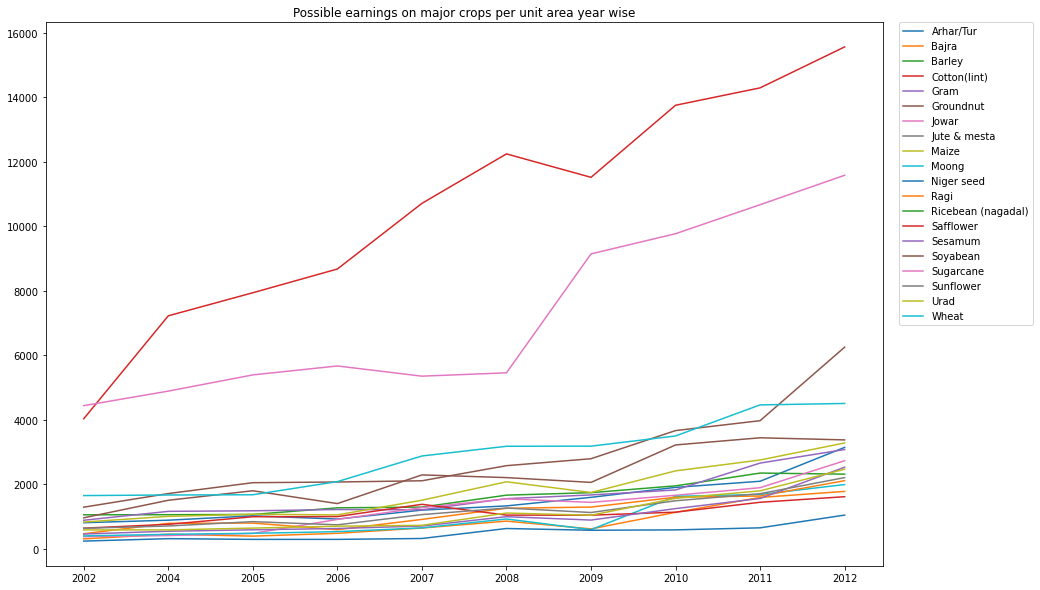

In [50]:
years= ratio_prod_area_earn.columns[1:]
fig = mplot.figure(figsize=(15,10))
ax1 = fig.add_subplot(111)
colormap = plt.cm.nipy_spectral
# ax1.set_color_cycle([colormap(i) for i in np.linspace(0, 1,ratio_prod_area_earn.shape[0])])
for i in range(ratio_prod_area_earn.shape[0]):
    ax1.plot(ratio_prod_area_earn.columns[1:],ratio_prod_area_earn.iloc[i,1:])
mplot.legend(ratio_prod_area_earn.iloc[:,0],bbox_to_anchor=(1.02,1), borderaxespad=0)
mplot.title('Possible earnings on major crops per unit area year wise')
mplot.show()

#### Taking data to compare with rainfall

In [51]:
prod_rain = crop_prod.copy()
prod_rain = prod_rain.loc[prod_rain.loc[:,'Crop_Year'] >=2000,:]
prod_rain = prod_rain.groupby(['State_Name','Crop_Year','Crop'],as_index=False,sort=False).sum()
prod_rain.iloc[:,0]=prod_rain.iloc[:,0].str.upper()
prod_rain = prod_rain.drop(columns = {'Crop','Production'})
prod_rain = prod_rain.groupby(['State_Name','Crop_Year'],as_index=False,sort=False).sum()
prod_rain.State_Name[prod_rain.State_Name == 'ANDAMAN AND NICOBAR ISLANDS'] = 'ANDAMAN & NICOBAR ISLANDS'
prod_rain.State_Name[prod_rain.State_Name == 'JAMMU AND KASHMIR '] = 'JAMMU & KASHMIR'
prod_rain.State_Name[prod_rain.State_Name == 'ODISHA'] = 'ORISSA'
prod_rain.State_Name[prod_rain.State_Name == 'TELANGANA '] = 'TELANGANA'
# prod_rain.head()

In [52]:
temp_rain = pd.concat([rainfall.iloc[:,0:2],rainfall.iloc[:,rainfall.shape[1]-1]],axis=1)
prod_rain = prod_rain[prod_rain['State_Name'].isin(temp_rain.STATES)]
temp_rain = temp_rain[temp_rain['STATES'].isin(prod_rain.State_Name)]
temp_rain.head()

,STATES,YEAR,ANNUAL
0,ANDAMAN & NICOBAR ISLANDS,2000,2763.2
1,ANDAMAN & NICOBAR ISLANDS,2001,3080.9
2,ANDAMAN & NICOBAR ISLANDS,2002,2620.2
3,ANDAMAN & NICOBAR ISLANDS,2003,2355.9
4,ANDAMAN & NICOBAR ISLANDS,2004,2460.1


In [53]:
area = crop_prod.copy()
area = area.loc[area.loc[:,'Crop_Year'] >=2000,:]
# area.drop(columns={'Production'},inplace=True)
area = area.groupby(['State_Name','Crop_Year','Crop'],as_index=False,sort=False).sum()
area_temp = area.drop(columns = 'Crop')
area_temp = area_temp.groupby(['State_Name','Crop_Year'],as_index=False,sort=False).sum()
area_temp.iloc[:,0]=area_temp.iloc[:,0].str.upper()
area_temp.State_Name[area_temp.State_Name == 'ANDAMAN AND NICOBAR ISLANDS'] = 'ANDAMAN & NICOBAR ISLANDS'
area_temp.State_Name[area_temp.State_Name == 'JAMMU AND KASHMIR '] = 'JAMMU & KASHMIR'
area_temp.State_Name[area_temp.State_Name == 'ODISHA'] = 'ORISSA'
area_temp.State_Name[area_temp.State_Name == 'TELANGANA '] = 'TELANGANA'
# area_temp.shape,temp_rain.shape
area_temp = area_temp[area_temp['State_Name'].isin(temp_rain.STATES)]
temp_rain = temp_rain[temp_rain['STATES'].isin(area_temp.State_Name)]
area_temp.head()
# ratio_prod_rain = pd.concat([prod_rain.iloc[:,0:3],prod_rain.Area*temp_rain.ANNUAL],axis=1)
# ratio_prod_rain

,State_Name,Crop_Year,Area,Production
0,ANDAMAN & NICOBAR ISLANDS,2000,44518.00,89060914.00
1,ANDAMAN & NICOBAR ISLANDS,2001,41163.00,89718700.00
2,ANDAMAN & NICOBAR ISLANDS,2002,45231.40,94387137.67
3,ANDAMAN & NICOBAR ISLANDS,2003,44799.40,95296454.67
4,ANDAMAN & NICOBAR ISLANDS,2004,45308.77,87186497.63


In [54]:
area_rainfall = pd.merge(area_temp.rename(columns={"State_Name": "STATES", "Crop_Year": "YEAR"}),temp_rain,how='inner')
area_rainfall.head()

,STATES,YEAR,Area,Production,ANNUAL
0,ANDAMAN & NICOBAR ISLANDS,2000,44518.00,89060914.00,2763.2
1,ANDAMAN & NICOBAR ISLANDS,2001,41163.00,89718700.00,3080.9
2,ANDAMAN & NICOBAR ISLANDS,2002,45231.40,94387137.67,2620.2
3,ANDAMAN & NICOBAR ISLANDS,2003,44799.40,95296454.67,2355.9
4,ANDAMAN & NICOBAR ISLANDS,2004,45308.77,87186497.63,2460.1


In [55]:
# area_rainfall.Area = area_rainfall.Production/(area_rainfall.Area*area_rainfall.ANNUAL)
# area_rainfall.head()

In [56]:
suicides.head()
suicides.rename(columns={'State/UT':'STATES'},inplace = True)

In [57]:
area_rainfall_plot = area_rainfall[area_rainfall['STATES'].isin(suicides.STATES)]
area_rainfall_plot.dropna()
suicides = suicides[suicides['STATES'].isin(area_rainfall_plot.STATES)]
area_rainfall_plot.shape

(312, 5)

#### Taking ratio of area * rainfall vs Production
- If this value is high it shows that the farmers had losses 

In [58]:
area_rainfall['Calc'] = (area_rainfall.Area*area_rainfall.ANNUAL)/area_rainfall.Production
# area_rainfall

In [59]:
area_rainfall = pd.merge(area_temp.rename(columns={"State_Name": "STATES", "Crop_Year": "YEAR"}),temp_rain,how='inner')
area_rain_no0=area_rainfall.copy()
# area_rain_no0.iloc[:,2:] = fill_0(area_rain_n0.iloc[:,2:])
area_rain_no0.head()

,STATES,YEAR,Area,Production,ANNUAL
0,ANDAMAN & NICOBAR ISLANDS,2000,44518.00,89060914.00,2763.2
1,ANDAMAN & NICOBAR ISLANDS,2001,41163.00,89718700.00,3080.9
2,ANDAMAN & NICOBAR ISLANDS,2002,45231.40,94387137.67,2620.2
3,ANDAMAN & NICOBAR ISLANDS,2003,44799.40,95296454.67,2355.9
4,ANDAMAN & NICOBAR ISLANDS,2004,45308.77,87186497.63,2460.1


#### Finding States that are affected by annual avg rainfall by area(i.e. Area vs Rainfall)
- This signifies which of the states are heavily dependent on rainfall for area under cultivation

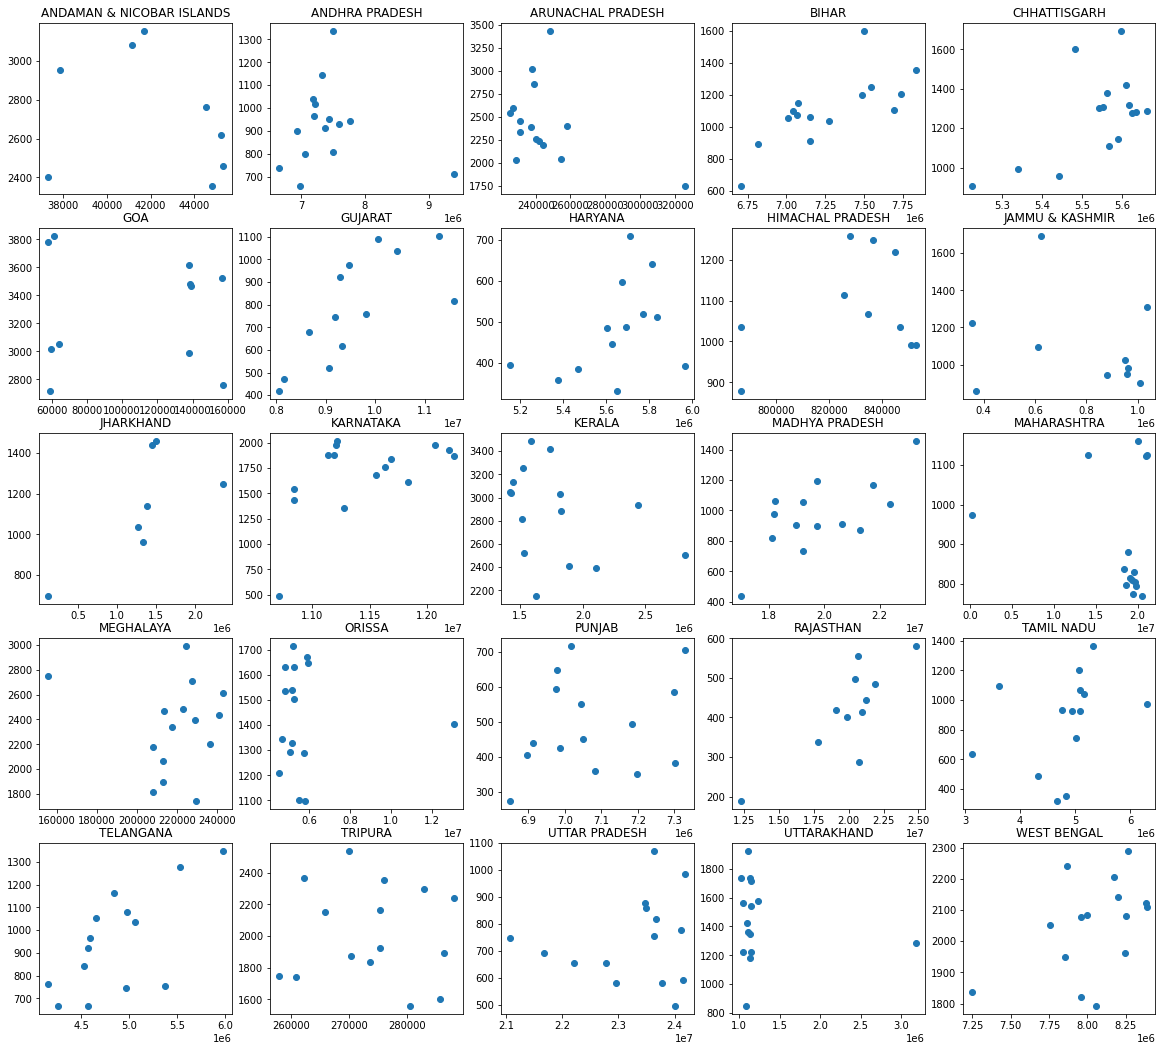

In [60]:
ct = 1
fig = mplot.figure(figsize=(20,22))
for i in area_rain_no0.STATES.unique():
    tp= area_rain_no0[area_rain_no0.STATES==i]
    tp=tp.iloc[:,2:] 
    mplot.subplot(6,5,ct)
    mplot.scatter(tp.iloc[:,0],tp.iloc[:,2])
    mplot.title(i)
    ct+=1
mplot.show()

#### Finding States that are affected by annual avg rainfall for Production(i.e. Production vs Rainfall)
- This signifies which states area affected by rainfall for production

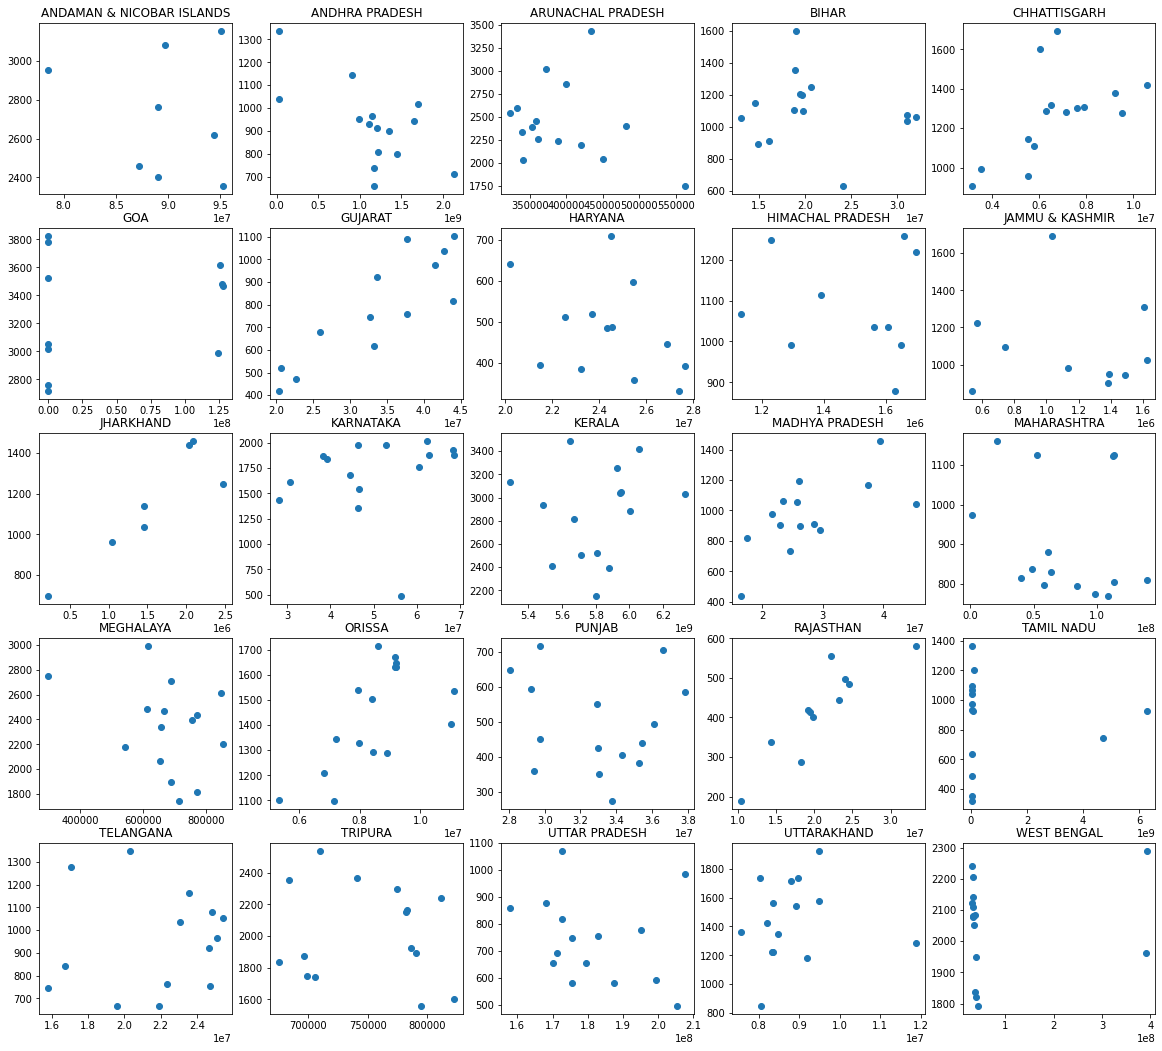

In [61]:
ct = 0
fig = mplot.figure(figsize=(20,22))
for i in area_rain_no0.STATES.unique():
    tp= area_rain_no0[area_rain_no0.STATES==i]
    tp=tp.iloc[:,2:]
    ct+=1
    mplot.subplot(6,5,ct)
    mplot.scatter(tp.iloc[:,1],tp.iloc[:,2])
    mplot.title(i)
mplot.show()

#### Finding States that are affected by annual avg rainfall by ratio of production and area(i.e. Production/Area vs Rainfall)
- This signifies in which states the ratio of products and area under cultivation is affected by Rainfall

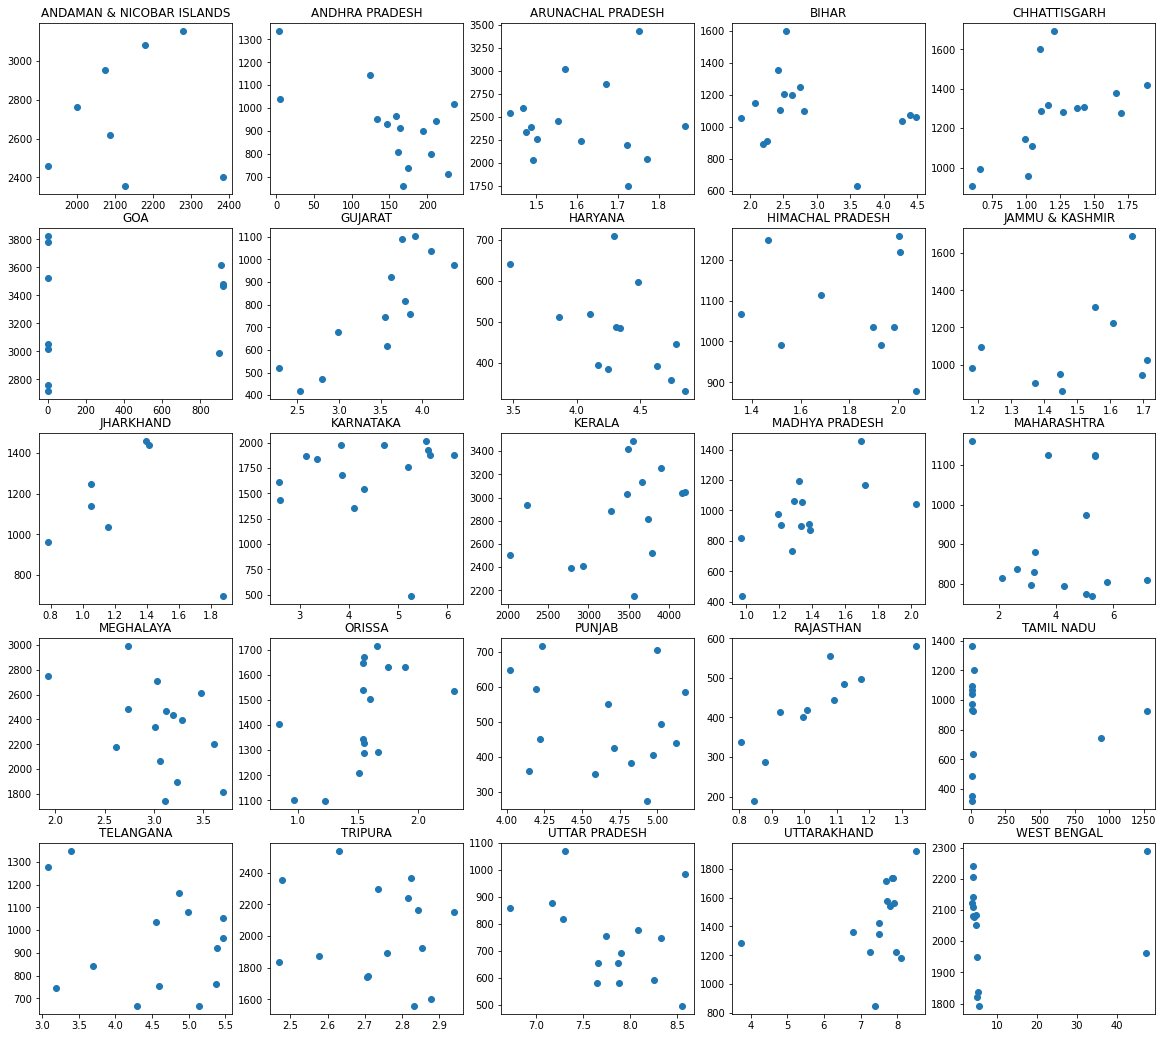

In [62]:
ct = 0
fig = mplot.figure(figsize=(20,22))
for i in area_rain_no0.STATES.unique():
    tp= area_rain_no0[area_rain_no0.STATES==i]
    tp=tp.iloc[:,2:]
    ct+=1
    mplot.subplot(6,5,ct)
    mplot.scatter(tp.iloc[:,1]/tp.iloc[:,0],tp.iloc[:,2])
    mplot.title(i)
mplot.show()

## Converting all data to merge into one table and then saving it in a csv file

In [63]:
area = crop_prod.copy()
area = area.loc[area.loc[:,'Crop_Year'] >=2000,:]
# area.drop(columns={'Production'},inplace=True)
area = area.groupby(['Crop_Year','Crop'],as_index=False,sort=False).sum()
# area_temp = area.drop(columns = 'Crop')
# area_temp = area_temp.groupby(['State_Name','Crop_Year'],as_index=False,sort=False).sum()
area_temp=area.copy()
# area_temp.shape,temp_rain.shape
# area_temp.head()

In [64]:
area_heat =pd.merge(area_temp.rename(columns={"Crop_Year": "YEAR"}),temperature.iloc[:,0:2],how='inner',sort=False)
area_heat['Ratio'] = area_heat.Production/area_heat.Area
# area_heat.head()

In [65]:
area = crop_prod.copy()
area = area.loc[area.loc[:,'Crop_Year'] >=2000,:]
# area.drop(columns={'Production'},inplace=True)
area = area.groupby(['State_Name','Crop_Year','Crop'],as_index=False,sort=False).sum()
area_temp=area.copy()
area_temp.iloc[:,0]=area_temp.iloc[:,0].str.upper()
area_temp.State_Name[area_temp.State_Name == 'ANDAMAN AND NICOBAR ISLANDS'] = 'ANDAMAN & NICOBAR ISLANDS'
area_temp.State_Name[area_temp.State_Name == 'JAMMU AND KASHMIR '] = 'JAMMU & KASHMIR'
area_temp.State_Name[area_temp.State_Name == 'ODISHA'] = 'ORISSA'
area_temp.State_Name[area_temp.State_Name == 'TELANGANA '] = 'TELANGANA'
area_temp.Crop[area_temp.Crop=='Paddy'] = 'Rice' 
area_temp.Crop[area_temp.Crop == 'Moong(Green Gram)'] = 'Moong'

In [66]:
temp_crop_price = crop_price.melt(id_vars=['Commodities'])
temp_crop_price.variable=temp_crop_price.variable.astype(int)

In [67]:
temp_cost = pd.concat([culti_cost.iloc[:,0:2],culti_cost.iloc[:,8:14]],axis=1)
years = temp_cost.columns[2:]
temp_cost.columns = list(temp_cost.columns[:2])+list([year[len(year)-7:len(year)-3] for year in years ])
temp_cost= temp_cost.melt(id_vars=['Crop','State/ UT Name'])
temp_cost.Crop[temp_cost.Crop=='Paddy'] = 'Rice'
temp_cost.Crop[temp_cost.Crop=='Arhar'] = 'Arhar/Tur'
temp_cost.Crop[temp_cost.Crop=='Cotton'] = 'Cotton(lint)'
temp_cost.Crop[temp_cost.Crop=='Rapeseed And Mustard'] = 'Rapeseed'
temp_cost.rename(columns={'State/ UT Name':'STATES'},inplace=True)
temp_cost.STATES = temp_cost.STATES.str.upper()
temp_cost.STATES[temp_cost.STATES=='ODISHA']='ORISSA'
temp_cost.variable = temp_cost.variable.astype(int)

In [68]:
temp_cost1 = pd.concat([culti_cost.iloc[:,0:2],culti_cost.iloc[:,14:19]],axis=1)
years = temp_cost1.columns[2:]
temp_cost1.columns = list(temp_cost1.columns[:2])+list([year[len(year)-7:len(year)-3] for year in years ])
temp_cost1= temp_cost1.melt(id_vars=['Crop','State/ UT Name'])
temp_cost1.Crop[temp_cost1.Crop=='Paddy'] = 'Rice'
temp_cost1.Crop[temp_cost1.Crop=='Arhar'] = 'Arhar/Tur'
temp_cost1.Crop[temp_cost1.Crop=='Cotton'] = 'Cotton(lint)'
temp_cost1.Crop[temp_cost1.Crop=='Rapeseed And Mustard'] = 'Rapeseed'
temp_cost1.rename(columns={'State/ UT Name':'STATES'},inplace=True)
temp_cost1.STATES = temp_cost.STATES.str.upper()
temp_cost1.STATES[temp_cost1.STATES=='ODISHA']='ORISSA'
temp_cost1.variable = temp_cost1.variable.astype(int)

In [69]:
temp_sui = suicides.copy()
temp_sui = temp_sui.melt(id_vars='STATES')
temp_sui.variable=temp_sui.variable.astype(int)

### Meging all data converted above

In [70]:
merged_all=pd.merge(area_temp.rename(columns={'State_Name':'STATES','Crop_Year':'YEAR' }),temp_rain.rename(columns={'ANNUAL':'Annual_Rain'}),how='left')
merged_all=pd.merge(merged_all,temperature.iloc[:,0:2].rename(columns={'ANNUAL':'Avg_Temperature'}),how='left')
merged_all=pd.merge(merged_all,temp_crop_price.rename(columns={'Commodities':'Crop','variable':'YEAR','value':'Price'}),how='left')
merged_all=pd.merge(merged_all,temp_cost.rename(columns={'variable':'YEAR','value':'Cost_per_Hectare'}),how='left')
merged_all=pd.merge(merged_all,temp_cost1.rename(columns={'variable':'YEAR','value':'Cost_per_quintal'}),how='left')
merged_all = pd.merge(merged_all,temp_sui.rename(columns={'variable':'YEAR','value':'Suicides'}),how='left')
merged_all = pd.merge(merged_all,exports.rename(columns = {'Product':'Crop','variable':'YEAR','value':'Export'}),how='left')
merged_all.head()

,STATES,YEAR,Crop,Area,Production,Annual_Rain,Avg_Temperature,Price,Cost_per_Hectare,Cost_per_quintal,Suicides,Export
0,ANDAMAN & NICOBAR ISLANDS,2000,Arecanut,4354.0,7200.0,2763.2,24.6,NaN,NaN,NaN,NaN,NaN
1,ANDAMAN & NICOBAR ISLANDS,2000,Other Kharif pulses,670.0,449.0,2763.2,24.6,NaN,NaN,NaN,NaN,NaN
2,ANDAMAN & NICOBAR ISLANDS,2000,Rice,10881.0,32184.0,2763.2,24.6,NaN,NaN,NaN,NaN,NaN
3,ANDAMAN & NICOBAR ISLANDS,2000,Banana,1707.0,12714.0,2763.2,24.6,NaN,NaN,NaN,NaN,NaN
4,ANDAMAN & NICOBAR ISLANDS,2000,Cashewnut,800.0,219.0,2763.2,24.6,NaN,NaN,NaN,NaN,NaN


#### Visualising Relationship between different features

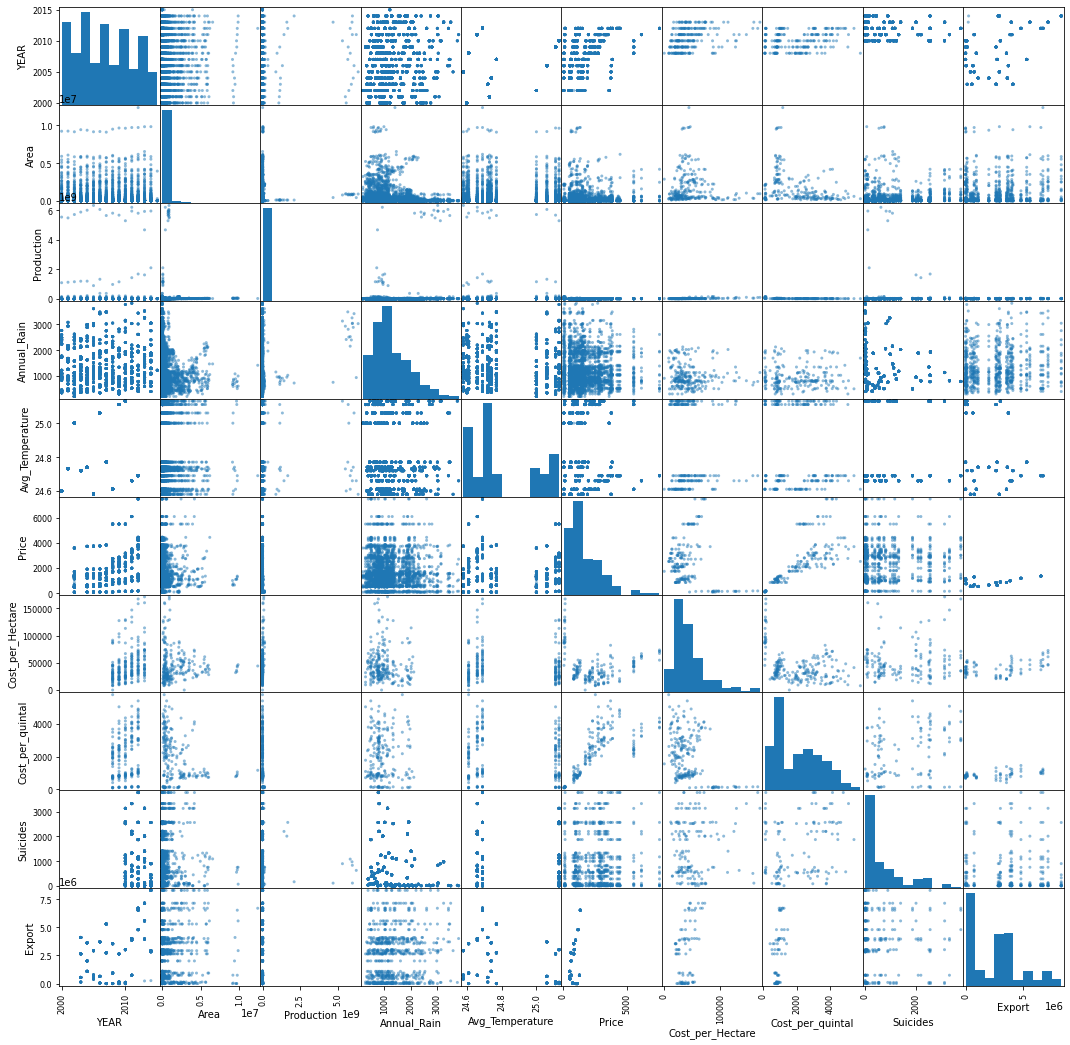

In [72]:
scat_plot = pd.plotting.scatter_matrix(merged_all,alpha=0.5,figsize=(18,18))
mplot.show()

In [73]:
merged_all = merged_all.fillna(0)
merged_all.shape

(11314, 12)

In [74]:
merged_all.to_csv('data_set.csv',index=False)

In [75]:
data = pd.read_csv('data_set.csv')
print(data.shape)
data.head()

(11314, 12)


,STATES,YEAR,Crop,Area,Production,Annual_Rain,Avg_Temperature,Price,Cost_per_Hectare,Cost_per_quintal,Suicides,Export
0,ANDAMAN & NICOBAR ISLANDS,2000,Arecanut,4354.0,7200.0,2763.2,24.6,0.0,0.0,0.0,0.0,0.0
1,ANDAMAN & NICOBAR ISLANDS,2000,Other Kharif pulses,670.0,449.0,2763.2,24.6,0.0,0.0,0.0,0.0,0.0
2,ANDAMAN & NICOBAR ISLANDS,2000,Rice,10881.0,32184.0,2763.2,24.6,0.0,0.0,0.0,0.0,0.0
3,ANDAMAN & NICOBAR ISLANDS,2000,Banana,1707.0,12714.0,2763.2,24.6,0.0,0.0,0.0,0.0,0.0
4,ANDAMAN & NICOBAR ISLANDS,2000,Cashewnut,800.0,219.0,2763.2,24.6,0.0,0.0,0.0,0.0,0.0


In [76]:
data_set = data[(data['YEAR'] >=2010)*(data['YEAR'] <=2014) ].fillna(0).groupby(['YEAR','Suicides']).agg('mean').reset_index()
# data_set.head()

### Finding correlation between different features

In [77]:
vals = data_set.corr()
vals

,YEAR,Suicides,Area,Production,Annual_Rain,Avg_Temperature,Price,Cost_per_Hectare,Cost_per_quintal,Export
YEAR,1.000000,-0.072314,0.018936,-0.021838,-0.068967,-0.844673,-0.554746,-0.089484,-0.268659,0.520077
Suicides,-0.072314,1.000000,0.569297,0.053705,-0.153630,0.078271,0.193278,0.629253,0.649622,-0.174800
Area,0.018936,0.569297,1.000000,-0.141455,-0.474405,-0.018899,0.220340,0.611186,0.529003,-0.068576
Production,-0.021838,0.053705,-0.141455,1.000000,0.338707,0.000170,-0.197971,-0.091603,-0.115446,-0.156324
Annual_Rain,-0.068967,-0.153630,-0.474405,0.338707,1.000000,0.011724,-0.295673,-0.394261,-0.348268,0.116749
Avg_Temperature,-0.844673,0.078271,-0.018899,0.000170,0.011724,1.000000,0.789468,0.108782,0.382569,-0.269068
Price,-0.554746,0.193278,0.220340,-0.197971,-0.295673,0.789468,1.000000,0.438663,0.627951,-0.094352
Cost_per_Hectare,-0.089484,0.629253,0.611186,-0.091603,-0.394261,0.108782,0.438663,1.000000,0.735738,0.036654
Cost_per_quintal,-0.268659,0.649622,0.529003,-0.115446,-0.348268,0.382569,0.627951,0.735738,1.000000,-0.096512
Export,0.520077,-0.174800,-0.068576,-0.156324,0.116749,-0.269068,-0.094352,0.036654,-0.096512,1.000000


### Visualization of correlation between features

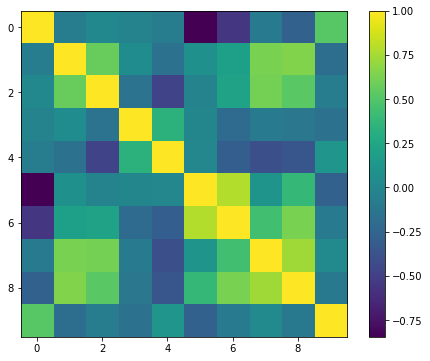

In [78]:
fig=mplot.figure(figsize=(8,6))
mplot.imshow(vals.values)
mplot.colorbar()
mplot.show()

#### Using linear regression to find the model for suicides

In [79]:
model = LR()
X = data_set.drop(columns = ['Suicides','YEAR'],axis=1)
y = data_set['Suicides']
tou = 1
Xx = X.values[y>tou]
Yy = y.values[y>tou]
v1 = Xx.mean(axis = 0)
v2 = Xx.std(axis = 0)
Xx = Xx - v1
Xx = Xx / v2
model.fit(Xx,Yy)
yd = model.predict(Xx)
model.score(Xx,Yy)

0.6126216293160907

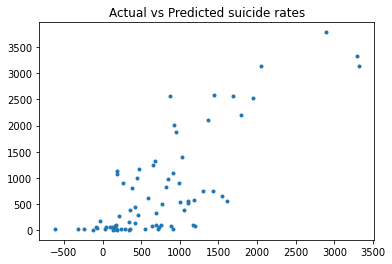

In [80]:
mplot.plot(yd,Yy,'.')
mplot.title('Actual vs Predicted suicide rates')
mplot.show()

#### Using CART method to find the model for suicide rates

In [81]:
model = scart(max_depth = 4)
model.fit(Xx,Yy)
model.score(Xx,Yy)

0.8387753603502259

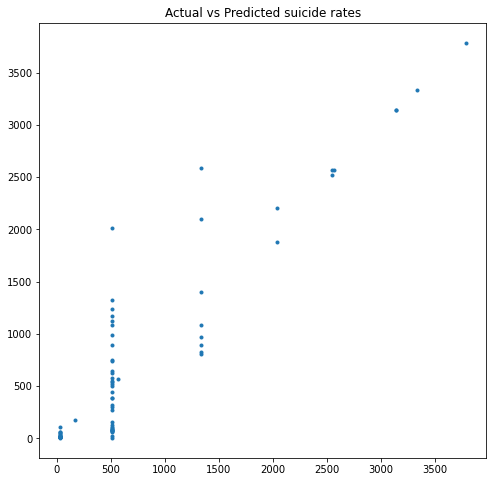

In [82]:
Yd = model.predict(Xx)
fig = mplot.figure(figsize=(8,8))
mplot.plot(Yd,Yy,'.')
mplot.title('Actual vs Predicted suicide rates')
# mplot.savefig('Figures/suicide_pred_cart_model')
mplot.show()

In [83]:
print(model.decision_path(Xx[0:1,:]))

  (0, 0)	1
  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (0, 5)	1


In [84]:
model.feature_importances_

array([0.67720487, 0.        , 0.0920977 , 0.        , 0.00443443,
       0.04239881, 0.18386419, 0.        ])

In [85]:
print(model.feature_importances_.argmax())
print(X.columns)

0
Index(['Area', 'Production', 'Annual_Rain', 'Avg_Temperature', 'Price',
       'Cost_per_Hectare', 'Cost_per_quintal', 'Export'],
      dtype='object')


In [93]:
data_set = data.fillna(0).groupby(['Crop','YEAR']).agg('mean').reset_index()
dicts = {}
for crop in data_set['Crop'].unique():
    
    X = data_set[data_set['Crop'] == crop]['YEAR'].values.reshape(-1,1)
    Y = data_set[data_set['Crop'] == crop]['Production'].values
    if(X.shape[0] > 5):
        linmodel = LR()
        linmodel.fit(X,Y)
        w = linmodel.coef_[0]
        dicts[crop] = [w]
#         print(w)

#### Finding the crops that have reduction in production over the years
- This will signify what crops are going be be rarely produced in future

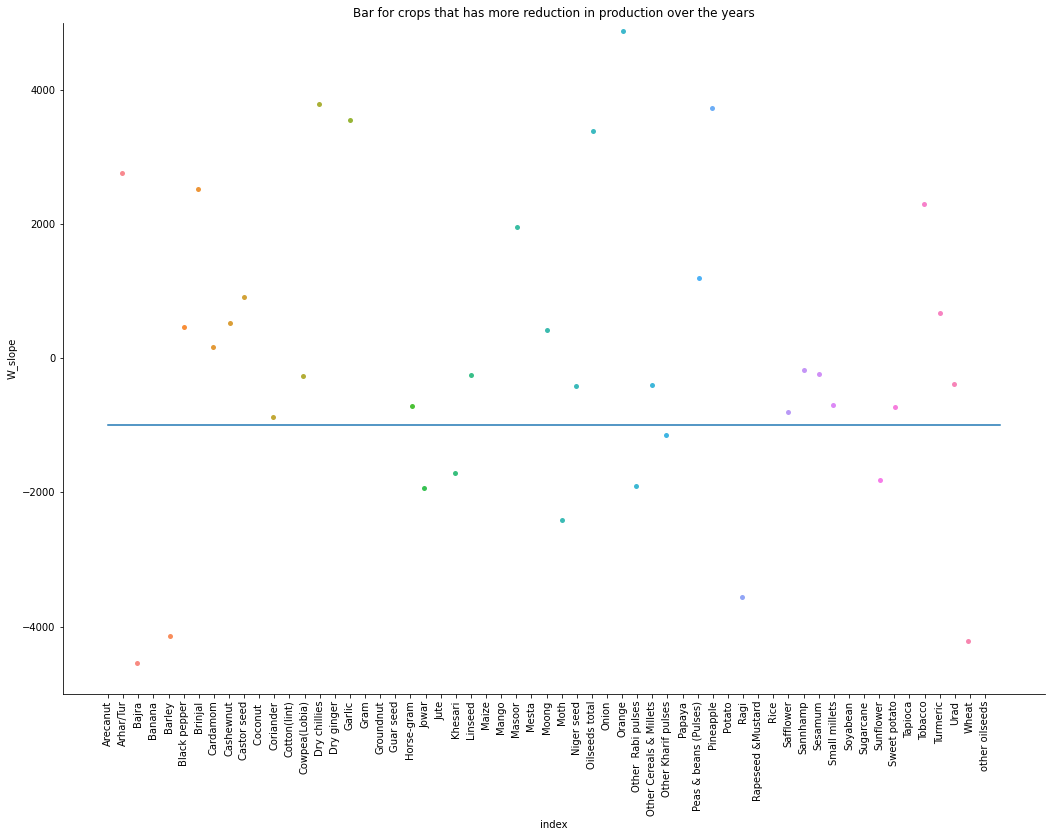

In [94]:
slope_data = pd.DataFrame(dicts).T.reset_index().rename(columns = {0:'W_slope'})
sns.catplot(x='index', y='W_slope', data = slope_data,  height=10, aspect=12/8.27);
plt.ylim(-5000,5000)
plt.xticks(rotation='vertical')
plt.plot([0,slope_data.shape[0]],[-1000,-1000])
plt.title('Bar for crops that has more reduction in production over the years')
# plt.savefig('Figures/Crops_reduction')
plt.show()

In [95]:
slope_data[slope_data.W_slope<-1000]

,index,W_slope
2,Bajra,-4537.162480
4,Barley,-4141.496114
18,Groundnut,-12034.886469
19,Guar seed,-12780.917262
21,Jowar,-1927.821737
22,Jute,-54720.777614
23,Khesari,-1717.234226
28,Mesta,-5094.770567
30,Moth,-2411.072500
35,Other Rabi pulses,-1908.905869


In [96]:
data_set = data.fillna(0).groupby(['Crop','YEAR']).agg('mean').reset_index()

#### Finding crops that have reduction in production but their price is increasing
- This signifies that these products demands are still there but there production quantity is reducing which means these crops might give better returns if taken up up by few farmers

In [97]:
dicts = {}
dicts2 = {}
dicts3 = {}
maxw = 0
for crop in data_set['Crop'].unique():
    X = data_set[data_set['Crop'] == crop]['YEAR'].values.reshape(-1,1)
    Y = data_set[data_set['Crop'] == crop]['Production'].values
    Y2 = data_set[data_set['Crop'] == crop]['Price'].values
    X = X[Y2 > 0]
    Y = Y[Y2 > 0]
    Y2 = Y2[Y2 > 0]
    if(X.shape[0] > 5):    
        linmodel = LR()
        linmodel.fit(X,Y)
        w = linmodel.coef_[0]
        linmodel.fit(X,Y2)
        w2 = linmodel.coef_[0]
        if(w > maxw):
            maxw = w
        if(w < 0 and w2 > 0):
            dicts[crop] = [w,w2]
        if(w < 10000 and w2 > 100): 
            dicts2[crop] = [w,w2]
        dicts3[crop] = [w,w2]

In [98]:
slope_data = pd.DataFrame(dicts).T.reset_index().rename(columns = {0:'production var',1:'price var'})
slope_data

,index,production var,price var
0,Barley,-129.610556,51.277056
1,Niger seed,-144.009443,249.534632
2,Safflower,-1031.251935,122.445887
3,Sunflower,-4511.467222,223.906926


#### Finding the crops which has lower increase in production but are increasing in price
- Gives inforamtion about what crops might be more prfitable to produce

In [99]:
slope_data = pd.DataFrame(dicts2).T.reset_index().rename(columns = {0:'production var',1:'price var'})
slope_data

,index,production var,price var
0,Arhar/Tur,5237.572915,260.551948
1,Groundnut,1758.235163,199.339827
2,Jowar,3648.323679,234.956710
3,Moong,941.797058,308.993506
4,Niger seed,-144.009443,249.534632
5,Safflower,-1031.251935,122.445887
6,Sesamum,1494.291172,279.404762
7,Sunflower,-4511.467222,223.906926
8,Urad,2670.533797,284.469697


In [100]:
slope_data = pd.DataFrame(dicts3).T.reset_index().rename(columns = {0:'production var',1:'price var'})
slope_data

,index,production var,price var
0,Arhar/Tur,5237.572915,260.551948
1,Bajra,13476.838875,69.145022
2,Barley,-129.610556,51.277056
3,Cotton(lint),98938.700867,379.372294
4,Gram,17651.118445,169.123377
5,Groundnut,1758.235163,199.339827
6,Jowar,3648.323679,234.956710
7,Maize,49300.778390,68.593074
8,Moong,941.797058,308.993506
9,Niger seed,-144.009443,249.534632


In [101]:
data_set = data.fillna(0).groupby(['Crop','YEAR']).agg('mean').reset_index()

In [102]:
dicts = {}
dicts2 = {}
dicts3 = {}
maxw = 0
for crop in data_set['Crop'].unique():
    
    X = data_set[data_set['Crop'] == crop]['YEAR'].values.reshape(-1,1)
    Y = data_set[data_set['Crop'] == crop]['Cost_per_Hectare'].values
    Y2 = data_set[data_set['Crop'] == crop]['Price'].values
    
    X = X[Y2 > 0]
    Y = Y[Y2 > 0]
    Y2 = Y2[Y2 > 0]
    
    if(X.shape[0] > 5):
        linmodel = LR()
        linmodel.fit(X,Y)
        w = linmodel.coef_[0]
        linmodel.fit(X,Y2)
        w2 = linmodel.coef_[0]
        
        if(w> 0):
            dicts3[crop] = [w,w2]
#         print(w)

#### Finding crops that have lower rate of increase in cost per hectare than price
- This gives us information of the products that might be more preffered due to ratio of returns being more over increase in cost per heactare

In [103]:
slope_data = pd.DataFrame(dicts3).T.reset_index().rename(columns = {0:'cost_per_hec var',1:'price var'})
slope_data['grow_ratio'] = (slope_data['cost_per_hec var']**-1)*slope_data['price var']
slope_data.sort_values(by = 'grow_ratio', ascending = False)

,index,cost_per_hec var,price var,grow_ratio
5,Moong,571.901298,308.993506,0.540292
0,Arhar/Tur,1155.433382,260.551948,0.225501
2,Gram,865.233108,169.123377,0.195466
1,Cotton(lint),2477.784265,379.372294,0.153109
3,Groundnut,1623.278151,199.339827,0.122801
4,Maize,868.141613,68.593074,0.079011
7,Wheat,1122.494264,81.904762,0.072967
6,Sugarcane,3281.720563,10.367338,0.003159


In [104]:
merged_all.columns

Index(['STATES', 'YEAR', 'Crop', 'Area', 'Production', 'Annual_Rain',
       'Avg_Temperature', 'Price', 'Cost_per_Hectare', 'Cost_per_quintal',
       'Suicides', 'Export'],
      dtype='object')

In [105]:
merged_all['invar'] = (merged_all['Production'])

In [106]:
state_crop = (merged_all[['STATES','Crop','invar']])
state_crop = state_crop.groupby(['STATES','Crop']).agg('sum').reset_index()
state_crop = state_crop.pivot(index='STATES',columns = 'Crop',values = 'invar')
#Use fill na as per your choice
state_crop = state_crop.fillna(0)
state_crop.head()

Crop,Apple,Arcanut (Processed),Arecanut,Arhar/Tur,Ash Gourd,Atcanut (Raw),Bajra,Banana,Barley,Bean,...,Turmeric,Turnip,Urad,Varagu,Water Melon,Wheat,Yam,other fibres,other misc. pulses,other oilseeds
STATES,,,,,,,,,,,,,,,,,,,,,
ANDAMAN & NICOBAR ISLANDS,0.0,0.0,48035.81,104.0,0.0,0.0,0.0,97424.65,0.0,0.0,...,1593.03,0.0,475.0,0.0,0.0,0.0,0.0,0.0,0.0,248.31
ANDHRA PRADESH,0.0,0.0,3784.00,1429055.0,0.0,0.0,1043457.0,15041631.00,0.0,0.0,...,1568134.00,0.0,3921961.0,3255.0,0.0,8560.0,0.0,0.0,1426.0,3595365.00
ARUNACHAL PRADESH,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,34933.00,0.0,0.0,0.0,0.0,87206.0,0.0,0.0,0.0,0.00
ASSAM,0.0,0.0,845536.00,72565.0,0.0,0.0,0.0,10559119.00,0.0,0.0,...,158551.00,0.0,338637.0,0.0,0.0,920224.0,0.0,0.0,6672.0,0.00
BIHAR,0.0,0.0,0.00,643465.0,0.0,0.0,47543.0,1913108.00,277542.0,0.0,...,24375.00,0.0,256575.0,0.0,0.0,68205141.0,0.0,0.0,0.0,0.00


In [107]:
dict1 = {}
for i,row in enumerate(state_crop.index):
#     print(i)
    dict1[row] = state_crop.columns[state_crop.iloc[i].argsort()[::-1][:13]]

In [108]:
pd.DataFrame(dict1).T

,0,1,2,3,4,5,6,7,8,9,10,11,12
ANDAMAN & NICOBAR ISLANDS,Coconut,Rice,Banana,Arecanut,Sugarcane,Dry ginger,Tapioca,Dry chillies,Sweet potato,Cashewnut,Turmeric,Black pepper,Other Kharif pulses
ANDHRA PRADESH,Coconut,Sugarcane,Rice,Maize,Cotton(lint),Banana,Groundnut,Mango,Gram,Dry chillies,Onion,Mesta,Urad
ARUNACHAL PRADESH,Rice,Maize,Dry ginger,Oilseeds total,Potato,Sugarcane,Small millets,Wheat,Dry chillies,Turmeric,Pulses total,Ginger,Coffee
ASSAM,Coconut,Rice,Sugarcane,Banana,Jute,Potato,Rapeseed &Mustard,Pineapple,Wheat,Orange,Arecanut,Papaya,Ginger
BIHAR,Sugarcane,Rice,Wheat,Maize,Jute,Potato,Mesta,Masoor,Banana,Moong,Khesari,Rapeseed &Mustard,Onion
CHANDIGARH,Wheat,Potato,Rice,Maize,Onion,Rapeseed &Mustard,Urad,Sunflower,Masoor,Moong,Gram,Kapas,Garlic
CHHATTISGARH,Rice,Khesari,Gram,Sugarcane,Maize,Wheat,Soyabean,Potato,Small millets,Groundnut,Urad,Onion,Arhar/Tur
DADRA AND NAGAR HAVELI,Sugarcane,Rice,Coconut,Other Rabi pulses,Ragi,Arhar/Tur,Wheat,Urad,Other Kharif pulses,Jowar,Banana,Small millets,Niger seed
GOA,Coconut,Rice,Sugarcane,Other Vegetables,Cashewnut,Other Fresh Fruits,Groundnut,Other Rabi pulses,Banana,Mango,Pineapple,Arecanut,Ragi
GUJARAT,Sugarcane,Cotton(lint),Wheat,Groundnut,Banana,Onion,Rice,Potato,Bajra,Castor seed,Maize,Rapeseed &Mustard,Arhar/Tur


currently growing high prodcution crops

In [109]:
from sklearn.decomposition import NMF

In [110]:
model = NMF(n_components=2, init='random', random_state=0)

In [111]:
X = state_crop.fillna(0).values

In [112]:
W = model.fit_transform(X)

In [113]:
H = model.components_

In [114]:
state_crop[:] = (np.dot(W,H))

In [115]:
state_crop.head()

Crop,Apple,Arcanut (Processed),Arecanut,Arhar/Tur,Ash Gourd,Atcanut (Raw),Bajra,Banana,Barley,Bean,...,Turmeric,Turnip,Urad,Varagu,Water Melon,Wheat,Yam,other fibres,other misc. pulses,other oilseeds
STATES,,,,,,,,,,,,,,,,,,,,,
ANDAMAN & NICOBAR ISLANDS,0.0,0.000000,12135.465665,0.000000,0.0,0.000000,0.000000e+00,1.173111e+05,0.000000,0.000000,...,4686.452904,0.000000,6171.923572,23.852929,0.0,0.000000e+00,0.0,0.0,3.090199,5335.951854
ANDHRA PRADESH,0.0,3428.557358,565197.625810,810214.143993,0.0,16486.611644,2.316559e+06,4.187615e+06,523248.049848,0.679980,...,181419.599501,0.015159,559416.268933,948.793128,0.0,3.403490e+07,0.0,0.0,92.239063,152460.418148
ARUNACHAL PRADESH,0.0,11.243802,921.748151,2657.061416,0.0,54.067113,7.597054e+03,4.725647e+03,1715.968814,0.002230,...,235.119570,0.000050,1360.684633,1.280035,0.0,1.116159e+05,0.0,0.0,0.065220,90.279007
ASSAM,0.0,422.965540,62643.643037,99952.436880,0.0,2033.878354,2.857834e+05,4.481446e+05,64550.733979,0.083886,...,19645.912385,0.001870,65410.727669,103.127802,0.0,4.198731e+06,0.0,0.0,9.575684,15694.304249
BIHAR,0.0,1952.177017,160034.024430,461325.643901,0.0,9387.267291,1.319019e+06,8.204575e+05,297930.794353,0.387172,...,40821.200362,0.008632,236244.351303,222.238642,0.0,1.937904e+07,0.0,0.0,11.323179,15673.502523


In [116]:
dict1 = {}
for i,row in enumerate(state_crop.index):
#     print(i)
    dict1[row] = state_crop.columns[state_crop.iloc[i].argsort()[::-1][:13]]

In [117]:
pd.DataFrame(dict1).T

,0,1,2,3,4,5,6,7,8,9,10,11,12
ANDAMAN & NICOBAR ISLANDS,Coconut,Tapioca,Rice,Banana,Groundnut,Sugarcane,Mango,Maize,Cotton(lint),Arecanut,Dry chillies,Onion,Rubber
ANDHRA PRADESH,Coconut,Sugarcane,Wheat,Rice,Potato,Tapioca,Banana,Maize,Cotton(lint),Bajra,Jowar,Groundnut,Gram
ARUNACHAL PRADESH,Sugarcane,Wheat,Rice,Potato,Maize,Cotton(lint),Bajra,Jowar,Banana,Soyabean,Gram,Groundnut,Rapeseed &Mustard
ASSAM,Coconut,Sugarcane,Wheat,Rice,Potato,Tapioca,Maize,Cotton(lint),Banana,Bajra,Jowar,Groundnut,Soyabean
BIHAR,Sugarcane,Wheat,Rice,Potato,Maize,Cotton(lint),Bajra,Jowar,Banana,Soyabean,Gram,Groundnut,Rapeseed &Mustard
CHANDIGARH,Sugarcane,Wheat,Rice,Potato,Maize,Cotton(lint),Bajra,Jowar,Banana,Soyabean,Gram,Groundnut,Rapeseed &Mustard
CHHATTISGARH,Sugarcane,Wheat,Rice,Potato,Maize,Cotton(lint),Bajra,Jowar,Banana,Soyabean,Gram,Groundnut,Rapeseed &Mustard
DADRA AND NAGAR HAVELI,Sugarcane,Wheat,Rice,Potato,Coconut,Maize,Cotton(lint),Bajra,Jowar,Banana,Soyabean,Gram,Groundnut
GOA,Coconut,Sugarcane,Rice,Tapioca,Wheat,Banana,Potato,Maize,Groundnut,Cotton(lint),Mango,Arecanut,Onion
GUJARAT,Sugarcane,Wheat,Rice,Potato,Maize,Cotton(lint),Bajra,Jowar,Banana,Soyabean,Gram,Groundnut,Rapeseed &Mustard


>This are recommended crops to grow in each state seperately based on the production trends. But as you will see coconut is not feasible in every state but since we are not considering soil data this is reasonable we can report if soil supports then these states can grow these crops which are likely to have high production per unit area.

#### Finding the cluster for crops using all the features

In [118]:
for_cluster = merged_all[['Crop', 'Area', 'Production', 'Annual_Rain','Avg_Temperature', 'Price', 'Cost_per_Hectare', 'Cost_per_quintal','Suicides']]
for_cluster = for_cluster.groupby(['Crop']).agg('mean').reset_index()
for_cluster = for_cluster.drop(28)
for_cluster.head()

,Crop,Area,Production,Annual_Rain,Avg_Temperature,Price,Cost_per_Hectare,Cost_per_quintal,Suicides
0,Apple,4.500000,0.000000,333.250000,24.860000,0.000000,0.000000,0.000000,0.000000
1,Arcanut (Processed),144116.000000,192831.000000,1359.800000,25.000000,0.000000,0.000000,0.000000,0.000000
2,Arecanut,51100.977692,183447.390962,1559.683173,22.175481,0.000000,0.000000,0.000000,214.115385
3,Arhar/Tur,155838.887774,105087.875258,989.948065,22.240129,1433.580645,2958.651581,250.928419,173.519355
4,Ash Gourd,822.000000,0.000000,333.250000,24.860000,0.000000,0.000000,0.000000,0.000000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

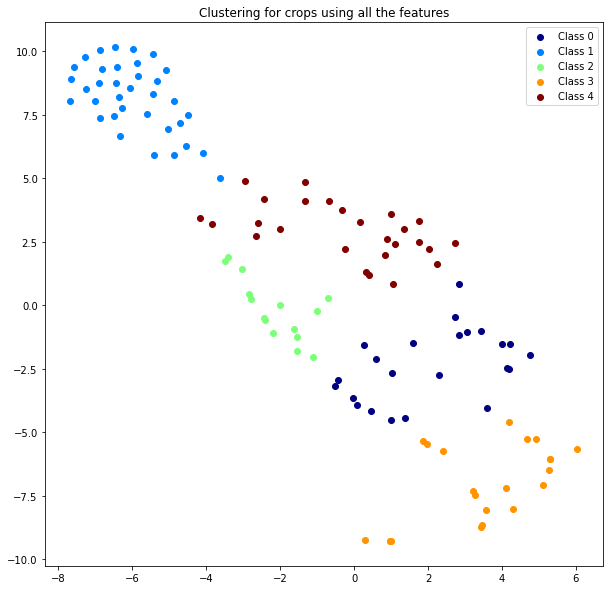

In [119]:
X = TSNE(n_components=2).fit_transform(for_cluster.iloc[:,1:])
k=5
kmeans = km(n_clusters=k, random_state=0).fit(X)
y = kmeans.labels_
list(set(y))
N= len(list(set(y)))
cmap = mplot.cm.jet
colors = cmap(np.linspace(0, 1, N))
fig = mplot.figure(figsize=(10,10))
for i in list(set(y)):
    mplot.scatter(X[y==i,0],X[y==i,1],c=colors[i],label=str('Class '+str(i)))
mplot.legend()
mplot.title('Clustering for crops using all the features')
# mplot.xlim(-15,)
# mplot.ylim(-20,)
mplot.show()

In [120]:
#### Crops falling in same cluster
for i in range(k):
    print('Cluster ',i,list(set(for_cluster.Crop[y==i].values)),'\n')

Cluster  0 ['Castor seed', 'Arecanut', 'Moong', 'other oilseeds', 'Barley', 'Ragi', 'Dry chillies', 'Arhar/Tur', 'Sesamum', 'Papaya', 'Cashewnut Raw', 'Sunflower', 'Orange', 'Masoor', 'Coffee', 'Arcanut (Processed)', 'Lemon', 'Sapota', 'Urad', 'Moth', 'Grapes', 'Khesari', 'Pineapple'] 

Cluster  1 ['Carrot', 'Peach', 'Pump Kin', 'Bitter Gourd', 'Redish', 'Litchi', 'Ricebean (nagadal)', 'Bean', 'Ribed Guard', 'Perilla', 'Varagu', 'other fibres', 'Cucumber', 'Peas  (vegetable)', 'Beet Root', 'Turnip', 'Kapas', 'Other Dry Fruit', 'Pear', 'Sannhamp', 'Other Citrus Fruit', 'Snak Guard', 'Lab-Lab', 'Apple', 'Water Melon', 'Cauliflower', 'Yam', 'Blackgram', 'other misc. pulses', 'Lentil', 'Ash Gourd', 'Plums', 'Bottle Gourd', 'Ber', 'Jobster'] 

Cluster  2 ['Citrus Fruit', 'Colocosia', 'Ginger', 'Cabbage', 'Mesta', 'Other Vegetables', 'Pome Fruit', 'Garlic', 'Sweet potato', 'Jute & mesta', 'Dry ginger', 'Brinjal', 'Turmeric', 'Tobacco', 'Bhindi'] 

Cluster  3 ['Soyabean', 'Cotton(lint)', 'Atc

#### Finding the clusters of states with year wise using all features

In [121]:
# print(merged_all.columns)
from sklearn.cluster import AgglomerativeClustering

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

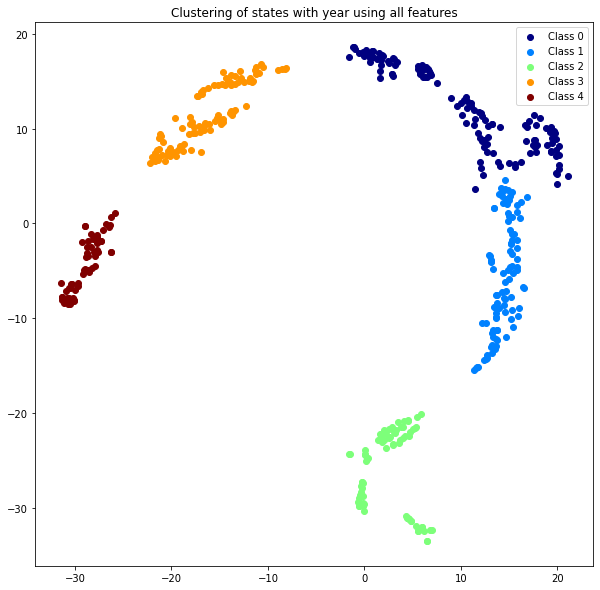

In [122]:
for_cluster = merged_all[['STATES','YEAR', 'Area', 'Production', 'Annual_Rain','Avg_Temperature', 'Price', 'Cost_per_Hectare', 'Cost_per_quintal','Suicides']]
for_cluster = for_cluster.groupby(['STATES','YEAR']).agg('mean').reset_index()
for_cluster.head()
X = TSNE(n_components=2).fit_transform(for_cluster.iloc[:,2:])
# k=4
# kmeans = km(n_clusters=k, random_state=0).fit(X)
# y = kmeans.labels_
clustering = AgglomerativeClustering(n_clusters=5).fit(X)
y=clustering.labels_
list(set(y))
N= len(list(set(y)))
cmap = mplot.cm.jet
colors = cmap(np.linspace(0, 1, N))
fig = mplot.figure(figsize=(10,10))
for i in list(set(y)):
    mplot.scatter(X[y==i,0],X[y==i,1],c=colors[i],label=str('Class '+str(i)))
mplot.legend()
mplot.title('Clustering of states with year using all features')
mplot.show()

In [123]:
#### Crops falling in same cluster
for i in range(k):
    print('Cluster ',i,list(set(for_cluster.STATES[y==i].values)),'\n')

Cluster  0 ['BIHAR', 'MAHARASHTRA', 'RAJASTHAN', 'TAMIL NADU', 'TELANGANA', 'ASSAM', 'MADHYA PRADESH', 'HIMACHAL PRADESH', 'JAMMU & KASHMIR', 'ANDHRA PRADESH', 'CHHATTISGARH', 'JHARKHAND', 'KARNATAKA', 'ORISSA', 'UTTARAKHAND', 'PUDUCHERRY', 'HARYANA', 'GUJARAT'] 

Cluster  1 ['BIHAR', 'MAHARASHTRA', 'TAMIL NADU', 'PUNJAB', 'WEST BENGAL', 'ANDHRA PRADESH', 'KARNATAKA', 'ORISSA', 'PUDUCHERRY', 'HARYANA', 'GUJARAT'] 

Cluster  2 ['TAMIL NADU', 'MAHARASHTRA', 'UTTAR PRADESH', 'WEST BENGAL', 'ASSAM', 'KERALA', 'ANDHRA PRADESH', 'ANDAMAN & NICOBAR ISLANDS', 'GOA'] 

Cluster  3 ['MAHARASHTRA', 'MANIPUR', 'MEGHALAYA', 'TRIPURA', 'SIKKIM', 'HIMACHAL PRADESH', 'JAMMU & KASHMIR', 'JHARKHAND', 'PUDUCHERRY', 'ARUNACHAL PRADESH', 'NAGALAND', 'GOA'] 

Cluster  4 ['MANIPUR', 'MEGHALAYA', 'CHANDIGARH', 'SIKKIM', 'DADRA AND NAGAR HAVELI', 'NAGALAND', 'MIZORAM'] 



#### Finding the crops with maximum production in each state

In [124]:
max_crop = merged_all[['STATES','YEAR','Crop','Production']]
max_crop = max_crop.groupby(['STATES','Crop']).agg('sum').reset_index()
max_crop.drop(columns='YEAR',inplace=True)
idx = max_crop.groupby(['STATES'])['Production'].transform(max) == max_crop['Production']
max_crop[idx]

,STATES,Crop,Production
5,ANDAMAN & NICOBAR ISLANDS,Coconut,7.177900e+08
32,ANDHRA PRADESH,Coconut,1.680600e+10
94,ARUNACHAL PRADESH,Rice,2.331049e+06
105,ASSAM,Coconut,1.654353e+09
169,BIHAR,Sugarcane,9.234307e+07
187,CHANDIGARH,Wheat,3.190500e+04
220,CHHATTISGARH,Rice,8.149862e+07
250,DADRA AND NAGAR HAVELI,Sugarcane,8.765550e+05
257,GOA,Coconut,5.031126e+08
293,GUJARAT,Sugarcane,1.725608e+08


#### Maximum produced crops in states year wise

In [125]:
max_crop_yearly = merged_all.groupby('STATES').agg('mean').reset_index()
max_crop_yearly = max_crop_yearly[['STATES']]
for i in merged_all.YEAR.unique():
    max_crop = merged_all[['STATES','YEAR','Crop','Production']]
    max_crop = max_crop[max_crop.YEAR==i]
    max_crop = max_crop.groupby(['STATES','Crop']).agg('sum').reset_index()
    max_crop.drop(columns='YEAR',inplace=True)
    idx = max_crop.groupby(['STATES'])['Production'].transform(max) == max_crop['Production']
    max_crop_yearly = pd.merge(max_crop_yearly,max_crop[idx][['STATES','Crop']].reset_index(),how='left')
    max_crop_yearly.drop(columns= {'index'},inplace=True)
    max_crop_yearly.rename(columns={'Crop':i},inplace=True)
max_crop_yearly.drop(columns={2015},inplace=True) # Since data for only Assam and Orrisa are available
max_crop_yearly

,STATES,2000,2001,2002,2003,2004,2005,2006,2010,2007,2008,2009,2011,2012,2013,2014
0,ANDAMAN & NICOBAR ISLANDS,Coconut,Coconut,Coconut,Coconut,Coconut,Coconut,Coconut,Coconut,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ANDHRA PRADESH,Coconut,Coconut,Coconut,Coconut,Coconut,Coconut,Coconut,Sugarcane,Sugarcane,Coconut,Coconut,Coconut,Coconut,Coconut,Coconut
2,ARUNACHAL PRADESH,Rice,Rice,Rice,Rice,Rice,Rice,Rice,Rice,Rice,Rice,Oilseeds total,Rice,Rice,Rice,Rice
3,ASSAM,Coconut,Coconut,Coconut,Coconut,Coconut,Rice,Coconut,Coconut,Coconut,Coconut,Coconut,Rice,Rice,Rice,Rice
4,BIHAR,Rice,Sugarcane,Rice,Rice,Sugarcane,Sugarcane,Rice,Sugarcane,Wheat,Rice,Wheat,Rice,Sugarcane,Sugarcane,Sugarcane
5,CHANDIGARH,Wheat,Wheat,Wheat,Wheat,Wheat,Wheat,Wheat,Wheat,Wheat,Wheat,Wheat,NaN,NaN,NaN,NaN
6,CHHATTISGARH,Rice,Rice,Rice,Rice,Rice,Rice,Rice,Rice,Rice,Rice,Rice,Rice,Rice,Rice,Rice
7,DADRA AND NAGAR HAVELI,Sugarcane,Sugarcane,Sugarcane,Sugarcane,Sugarcane,Sugarcane,Sugarcane,Sugarcane,Rice,Rice,Rice,Sugarcane,Sugarcane,Rice,Rice
8,GOA,NaN,NaN,NaN,NaN,Coconut,Coconut,Coconut,Rice,Coconut,Rice,Rice,Rice,Rice,Rice,Rice
9,GUJARAT,Sugarcane,Sugarcane,Sugarcane,Sugarcane,Sugarcane,Sugarcane,Sugarcane,Sugarcane,Sugarcane,Sugarcane,Sugarcane,Sugarcane,Cotton(lint),NaN,NaN
